# 환율 예측 모델링

### 1. LSTM

In [ ]:
import os
import random
import json
import time
from dataclasses import dataclass
from typing import Dict, Any, Tuple, List, Optional

import numpy as np
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# -------------------------
# 로그/디바이스 설정
# -------------------------

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
tf.get_logger().setLevel("ERROR")

print("TF:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())
print("GPU:", tf.config.list_physical_devices("GPU"))

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass


# -------------------------
# 설정
# -------------------------
CSV_PATH   = "./2026/data/df_final_2026_with_gdelt_and_news.csv"
DATE_COL   = "date"
TARGET_COL = "USD_KRW 종가"

SHIFT_LIST     = [1]
LOOKBACK_LIST  = [5, 10, 20, 30, 60, 90]

# LSTM only
MODEL_LIST     = ["LSTM"]
CASES          = ["Macro Only", "Macro + Event", "Macro + Sentiment", "ALL"]

TEST_HOLDOUT_RATIO = 0.20

# TS-CV (train_dev 내부)
CV_N_FOLDS   = 5
CV_TEST_SIZE = 0.12
CV_MIN_TRAIN = 0.55

# 기본 튜닝 budget (lookback별로 아래에서 가변 적용)
N_TRIALS_DEFAULT = 12
SEEDS_DEFAULT    = [42]        
EPOCHS_DEFAULT   = 80
BATCH_DEFAULT    = 64

OUT_DIR = "./output_paper_protocol_lstm_resume"
os.makedirs(OUT_DIR, exist_ok=True)

# 부분저장 파일들
TRIALS_PARTIAL_PATH   = os.path.join(OUT_DIR, "tuning_trials_partial.csv")
BESTCV_PARTIAL_PATH   = os.path.join(OUT_DIR, "best_cv_partial.csv")
CVPRED_PARTIAL_PATH   = os.path.join(OUT_DIR, "best_cv_predictions_partial.csv")
HOLDOUT_PARTIAL_PATH  = os.path.join(OUT_DIR, "holdout_results_partial.csv")
HOPRED_PARTIAL_PATH   = os.path.join(OUT_DIR, "holdout_predictions_partial.csv")
STATUS_PATH           = os.path.join(OUT_DIR, "run_status.json")

# 튜닝 조기 종료 기준
TUNE_EARLYSTOP_RMSE_TARGET = {

    "_global": 7.00
}
TUNE_NO_IMPROVE_PATIENCE_TRIALS = 4  
TUNE_MIN_IMPROVEMENT = 0.005         

MIN_TE_SEQS = 5  


# -------------------------
# Lookback별 속도 튜닝 
# -------------------------
@dataclass
class SpeedPlan:
    epochs: int
    batch: int
    es_patience: int
    rlrop_patience: int
    n_trials: int
    seeds: List[int]

def get_speed_plan(lookback: int) -> SpeedPlan:

    if lookback >= 90:
        return SpeedPlan(epochs=25, batch=128, es_patience=3, rlrop_patience=2,
                         n_trials=min(6, N_TRIALS_DEFAULT), seeds=SEEDS_DEFAULT)
    if lookback >= 60:
        return SpeedPlan(epochs=30, batch=128, es_patience=3, rlrop_patience=2,
                         n_trials=min(8, N_TRIALS_DEFAULT), seeds=SEEDS_DEFAULT)
    if lookback >= 30:
        return SpeedPlan(epochs=45, batch=96, es_patience=4, rlrop_patience=2,
                         n_trials=min(10, N_TRIALS_DEFAULT), seeds=SEEDS_DEFAULT)
    # 5~20은 기본에 가깝게
    return SpeedPlan(epochs=60, batch=BATCH_DEFAULT, es_patience=5, rlrop_patience=3,
                     n_trials=N_TRIALS_DEFAULT, seeds=SEEDS_DEFAULT)


# -------------------------
# 공통 유틸
# -------------------------
def set_seed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def eval_metrics(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)

    denom = np.maximum(np.abs(y_true), eps)
    ape   = np.abs(y_true - y_pred) / denom
    spe   = ((y_true - y_pred) / denom) ** 2

    mape   = float(np.mean(ape) * 100.0)
    mspe   = float(np.mean(spe) * 100.0)
    medae  = float(np.median(np.abs(y_true - y_pred)))
    medape = float(np.median(ape) * 100.0)

    return dict(MSE=mse, RMSE=rmse, MAE=mae, MAPE=mape, MSPE=mspe, MedAE=medae, MedAPE=medape)

def make_sequences_residual_with_dates(X, y, dates, lookback, shift=1):

    X_seq, y_d, p_last, y_true, target_dates = [], [], [], [], []
    n = len(y)
    max_i = n - lookback - shift
    for i in range(max_i):
        idx_last   = i + lookback - 1
        target_idx = idx_last + shift
        prev_idx   = target_idx - 1

        X_seq.append(X[i:i+lookback])
        y_d.append(y[target_idx] - y[prev_idx])
        p_last.append(y[prev_idx])
        y_true.append(y[target_idx])
        target_dates.append(dates[target_idx])

    return (np.array(X_seq, np.float32),
            np.array(y_d,   np.float32),
            np.array(p_last, np.float32),
            np.array(y_true, np.float32),
            np.array(target_dates))

def final_holdout_split(df, ratio=0.2):
    n = len(df)
    n_test = int(np.floor(n * ratio))
    n_test = max(1, n_test)
    split = n - n_test
    tr_dev = df.iloc[:split].reset_index(drop=True)
    te     = df.iloc[split:].reset_index(drop=True)
    return tr_dev, te

def walk_forward_splits(n, n_folds=5, test_size=0.12, min_train=0.55):
    test_len = max(2, int(n * test_size))
    start_test = int(n * min_train)

    splits = []
    for k in range(n_folds):
        te_start = start_test + k * test_len
        te_end   = min(n, te_start + test_len)
        if te_end - te_start < 5:
            break
        tr_end = te_start
        if tr_end < 30:
            continue
        splits.append((slice(0, tr_end), slice(te_start, te_end)))
        if te_end >= n:
            break
    return splits


# -------------------------
# 세트 자동 추론
# -------------------------
def infer_gdelt_cols(df):
    return [c for c in df.columns if c.startswith("gkg_") or c.startswith("events_")]

def infer_news_cols(df):
    news_like = []
    for c in df.columns:
        if c.startswith("news_") or c.startswith("sent_"):
            news_like.append(c)
    for c in ["abs_sent_mean", "pos_ratio", "neg_ratio", "neu_ratio", "direct_ratio", "indirect_ratio",
              "sent_net_ratio", "sent_net_count", "sent_std"]:
        if c in df.columns:
            news_like.append(c)
    return sorted(list(set(news_like)))

def build_case_df(df_raw: pd.DataFrame, case_name: str):
    gdelt_cols = infer_gdelt_cols(df_raw)
    news_cols  = infer_news_cols(df_raw)

    numeric_cols = [c for c in df_raw.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
    macro_cols = [c for c in numeric_cols if (c not in gdelt_cols and c not in news_cols)]

    if case_name == "Macro Only":
        keep = [DATE_COL, TARGET_COL] + macro_cols
    elif case_name == "Macro + Event":
        keep = [DATE_COL, TARGET_COL] + macro_cols + gdelt_cols
    elif case_name == "Macro + Sentiment":
        keep = [DATE_COL, TARGET_COL] + macro_cols + news_cols
    elif case_name == "ALL":
        keep = [DATE_COL, TARGET_COL] + macro_cols + gdelt_cols + news_cols
    else:
        raise ValueError(f"Unknown case: {case_name}")

    df_case = df_raw[keep].copy()
    df_case = df_case.sort_values(DATE_COL).dropna(subset=[DATE_COL, TARGET_COL]).reset_index(drop=True)
    df_case = df_case.replace([np.inf, -np.inf], np.nan).dropna()
    return df_case


# -------------------------
# 모델 빌더 
# -------------------------
def build_model_lstm(input_shape, hp):

    lr = hp["lr"]

    RNN_KW = dict(recurrent_dropout=0.10)  
    m = Sequential([
        Input(shape=input_shape),
        LSTM(hp["rnn1"], return_sequences=True, **RNN_KW),
        Dropout(hp["dropout"]),
        LSTM(hp["rnn2"], **RNN_KW),
        Dropout(hp["dropout"]),
        Dense(1),
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    m.compile(optimizer=opt, loss="mse")
    return m


# -------------------------
# Random Search 공간
# -------------------------
def sample_hp(rng: np.random.RandomState):
    # 외부 Dropout 레이어만 사용 (0.05~0.20)
    return {
        "lr": float(rng.choice([1e-3, 5e-4, 3e-4, 1e-4])),
        "dropout": float(rng.choice([0.05, 0.10, 0.15, 0.20])),
        "rnn1": int(rng.choice([32, 48, 64, 96, 128])),
        "rnn2": int(rng.choice([16, 24, 32, 48, 64])),
    }


# -------------------------
# 저장/재개 도구
# -------------------------
def _safe_append_csv(df: pd.DataFrame, path: str):
    if df is None or len(df) == 0:
        return
    if not os.path.exists(path):
        df.to_csv(path, index=False, encoding="utf-8-sig")
    else:
        df.to_csv(path, index=False, mode="a", header=False, encoding="utf-8-sig")

def load_partial(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        try:
            return pd.read_csv(path, encoding="utf-8-sig")
        except Exception:
            # 인코딩/깨짐 대비
            return pd.read_csv(path)
    return pd.DataFrame()

def key_str(case: str, model: str, lookback: int, shift: int) -> str:
    return f"{case}||{model}||lb={lookback}||shift={shift}"

def trial_key(case: str, model: str, lookback: int, shift: int, trial: int) -> str:
    return f"{key_str(case, model, lookback, shift)}||trial={trial}"

def holdout_key(case: str, model: str, lookback: int, shift: int) -> str:
    return f"{key_str(case, model, lookback, shift)}||HOLDOUT"

def save_status(status: Dict[str, Any]):
    with open(STATUS_PATH, "w", encoding="utf-8") as f:
        json.dump(status, f, ensure_ascii=False, indent=2)

def load_status() -> Dict[str, Any]:
    if os.path.exists(STATUS_PATH):
        with open(STATUS_PATH, "r", encoding="utf-8") as f:
            return json.load(f)
    return {"started_at": None, "updated_at": None}


# -------------------------
# Fold 학습/예측 (CV) - fold 스킵 포함
# -------------------------
def fit_predict_fold(df_case, hp, seed, lookback, shift, tr_sl, te_sl, sp: SpeedPlan):
    set_seed(seed)
    tf.keras.backend.clear_session()

    feats = [c for c in df_case.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
    X_all = df_case[feats].values.astype(np.float32)
    y_all = df_case[TARGET_COL].values.astype(np.float32)
    dates = df_case[DATE_COL].values

    X_tr_raw, y_tr_raw, d_tr = X_all[tr_sl], y_all[tr_sl], dates[tr_sl]
    X_te_raw, y_te_raw, d_te = X_all[te_sl], y_all[te_sl], dates[te_sl]

    x_scaler = RobustScaler()
    X_tr = x_scaler.fit_transform(X_tr_raw)
    X_te = x_scaler.transform(X_te_raw)

    X_tr_seq, y_d_tr_raw, _, _, _ = make_sequences_residual_with_dates(X_tr, y_tr_raw, d_tr, lookback, shift=shift)
    if len(X_tr_seq) < 25:
        raise ValueError("train sequence too short (fold)")

    d_scaler = RobustScaler()
    y_d_tr_sc = d_scaler.fit_transform(y_d_tr_raw.reshape(-1, 1)).ravel()

    n_tr_seq = len(X_tr_seq)
    val_sz = max(2, int(n_tr_seq * 0.1))
    X_train, y_train = X_tr_seq[:-val_sz], y_d_tr_sc[:-val_sz]
    X_val,   y_val   = X_tr_seq[-val_sz:],  y_d_tr_sc[-val_sz:]

    X_te_seq, y_d_te_raw, p_last_te, y_true_te, target_dates = make_sequences_residual_with_dates(
        X_te, y_te_raw, d_te, lookback, shift=shift
    )
    if len(X_te_seq) < MIN_TE_SEQS:
        raise ValueError("test sequence too short (fold)")

    cbs = [
        EarlyStopping(monitor="val_loss", patience=sp.es_patience, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=sp.rlrop_patience, min_lr=1e-5, verbose=0),
    ]

    model = build_model_lstm((lookback, X_train.shape[-1]), hp)
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=sp.epochs,
        batch_size=sp.batch,
        callbacks=cbs,
        verbose=0,
    )

    d_pred_sc = model.predict(X_te_seq, verbose=0).ravel()
    d_pred = d_scaler.inverse_transform(d_pred_sc.reshape(-1, 1)).ravel()
    yhat = p_last_te + d_pred

    metrics = eval_metrics(y_true_te, yhat)
    pred_df = pd.DataFrame({"date": target_dates, "y_true": y_true_te, "y_pred": yhat})
    return metrics, pred_df

def cv_score_train_dev(df_train_dev, hp, seed, lookback, shift, sp: SpeedPlan):
    splits = walk_forward_splits(len(df_train_dev), n_folds=CV_N_FOLDS, test_size=CV_TEST_SIZE, min_train=CV_MIN_TRAIN)
    if len(splits) == 0:
        raise ValueError("No CV splits produced. Check CV_MIN_TRAIN/CV_TEST_SIZE.")

    fold_metrics = []
    fold_preds = []
    skipped = 0

    for f, (tr_sl, te_sl) in enumerate(splits):
        try:
            m, p = fit_predict_fold(df_train_dev, hp, seed, lookback, shift, tr_sl, te_sl, sp)
        except ValueError:
            skipped += 1
            continue

        m["fold"] = f
        fold_metrics.append(m)
        p["fold"] = f
        fold_preds.append(p)

    if len(fold_metrics) == 0:
        raise ValueError("All folds skipped (test sequence too short). Reduce LOOKBACK / adjust CV settings.")

    met_df  = pd.DataFrame(fold_metrics)
    pred_df = pd.concat(fold_preds, ignore_index=True) if len(fold_preds) else pd.DataFrame()

    avg = met_df.mean(numeric_only=True).to_dict()
    avg["skipped_folds"] = skipped
    avg["used_folds"] = len(fold_metrics)
    return avg, met_df, pred_df


# -------------------------
# 최종 평가 (hold-out)
# -------------------------
def fit_on_train_dev_and_eval_on_holdout(df_train_dev, df_test, hp, seed, lookback, shift, sp: SpeedPlan):
    set_seed(seed)
    tf.keras.backend.clear_session()

    feats = [c for c in df_train_dev.select_dtypes(include=[np.number]).columns if c != TARGET_COL]

    X_tr_raw = df_train_dev[feats].values.astype(np.float32)
    y_tr_raw = df_train_dev[TARGET_COL].values.astype(np.float32)
    d_tr     = df_train_dev[DATE_COL].values

    X_te_raw = df_test[feats].values.astype(np.float32)
    y_te_raw = df_test[TARGET_COL].values.astype(np.float32)
    d_te     = df_test[DATE_COL].values

    x_scaler = RobustScaler()
    X_tr = x_scaler.fit_transform(X_tr_raw)
    X_te = x_scaler.transform(X_te_raw)

    X_tr_seq, y_d_tr_raw, _, _, _ = make_sequences_residual_with_dates(X_tr, y_tr_raw, d_tr, lookback, shift=shift)
    if len(X_tr_seq) < 30:
        raise ValueError("train_dev sequence too short")

    d_scaler = RobustScaler()
    y_d_tr_sc = d_scaler.fit_transform(y_d_tr_raw.reshape(-1, 1)).ravel()

    n_tr_seq = len(X_tr_seq)
    val_sz = max(2, int(n_tr_seq * 0.1))
    X_train, y_train = X_tr_seq[:-val_sz], y_d_tr_sc[:-val_sz]
    X_val,   y_val   = X_tr_seq[-val_sz:],  y_d_tr_sc[-val_sz:]

    X_te_seq, y_d_te_raw, p_last_te, y_true_te, target_dates = make_sequences_residual_with_dates(
        X_te, y_te_raw, d_te, lookback, shift=shift
    )
    if len(X_te_seq) < MIN_TE_SEQS:
        raise ValueError("holdout test sequence too short")

    cbs = [
        EarlyStopping(monitor="val_loss", patience=sp.es_patience, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=sp.rlrop_patience, min_lr=1e-5, verbose=0),
    ]

    model = build_model_lstm((lookback, X_train.shape[-1]), hp)
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=sp.epochs,
        batch_size=sp.batch,
        callbacks=cbs,
        verbose=0,
    )

    d_pred_sc = model.predict(X_te_seq, verbose=0).ravel()
    d_pred = d_scaler.inverse_transform(d_pred_sc.reshape(-1, 1)).ravel()
    yhat = p_last_te + d_pred

    metrics = eval_metrics(y_true_te, yhat)
    pred_df = pd.DataFrame({"date": target_dates, "y_true": y_true_te, "y_pred": yhat})
    return metrics, pred_df


# -------------------------
# 튜닝/선택(train_dev only) + 조기 종료 + 실패 trial 기록 + resume
# -------------------------
def tune_select_on_train_dev_resumable(
    df_train_dev: pd.DataFrame,
    case_name: str,
    model_name: str,
    lookback: int,
    shift: int,
    sp: SpeedPlan,
    done_trials_set: set
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, Any]]:
    """
    반환:
      - trials_df_new: 이번 실행에서 "새로" 수행한 trial row들(성공/실패 포함)
      - best_cv_df: best 요약(1 row)
      - best_preds_df: best trial의 cv 예측(통합)
      - best_info: dict(best_score, best_hp, used_trials, early_stopped_reason)
    """
    assert model_name == "LSTM"

    base_seed = 2026
    rng = np.random.RandomState(base_seed + (abs(hash((case_name, model_name, lookback, shift))) % 100000))

    trial_rows_new = []
    best = None 

    best_score = np.inf
    no_improve = 0
    early_reason = None

    rmse_target = TUNE_EARLYSTOP_RMSE_TARGET.get(case_name, TUNE_EARLYSTOP_RMSE_TARGET.get("_global", None))

    for t in range(sp.n_trials):
        tkey = trial_key(case_name, model_name, lookback, shift, t)
        if tkey in done_trials_set:
            continue

        hp = sample_hp(rng)
        t0 = time.time()

        try:
            seed_metrics = []
            seed_pred_list = []

            for sd in sp.seeds:
                avg, met_df, pred_df = cv_score_train_dev(df_train_dev, hp, sd, lookback, shift, sp)
                avg["seed"] = sd
                seed_metrics.append(avg)

                pred_df = pred_df.copy()
                pred_df["seed"] = sd
                seed_pred_list.append(pred_df)

            seed_metrics_df = pd.DataFrame(seed_metrics)
            score = float(seed_metrics_df["RMSE"].mean())

            row = {
                "key": key_str(case_name, model_name, lookback, shift),
                "trial_key": tkey,
                "status": "OK",
                "case": case_name,
                "model": model_name,
                "lookback": lookback,
                "shift": shift,
                "trial": t,
                "score_RMSE_mean_over_seeds": score,
                "MAE_mean": float(seed_metrics_df["MAE"].mean()),
                "MAPE_mean": float(seed_metrics_df["MAPE"].mean()),
                "MedAE_mean": float(seed_metrics_df["MedAE"].mean()),
                "MedAPE_mean": float(seed_metrics_df["MedAPE"].mean()),
                "hp_json": json.dumps(hp, ensure_ascii=False),
                "used_folds_mean": float(seed_metrics_df.get("used_folds", pd.Series([np.nan])).mean()),
                "skipped_folds_mean": float(seed_metrics_df.get("skipped_folds", pd.Series([np.nan])).mean()),
                "seconds": float(time.time() - t0),
            }
            trial_rows_new.append(row)

            # best 갱신
            improved = (best is None) or (score < (best_score - TUNE_MIN_IMPROVEMENT))
            if improved:
                best_score = score
                no_improve = 0
                best = (score, hp, seed_metrics_df, pd.concat(seed_pred_list, ignore_index=True))
            else:
                no_improve += 1

            print(f"[TUNE] case={case_name} model={model_name} lb={lookback} trial={t+1}/{sp.n_trials} RMSE={score:.4f}")

            if (rmse_target is not None) and (best_score <= rmse_target):
                early_reason = f"best_RMSE({best_score:.4f}) <= target({rmse_target})"
                break

            if no_improve >= TUNE_NO_IMPROVE_PATIENCE_TRIALS:
                early_reason = f"no_improve_trials>={TUNE_NO_IMPROVE_PATIENCE_TRIALS}"
                break

        except Exception as e:
            msg = str(e)
            print(f"[TUNE-FAIL] case={case_name} model={model_name} lb={lookback} trial={t+1}/{sp.n_trials} -> {msg[:200]}")

            trial_rows_new.append({
                "key": key_str(case_name, model_name, lookback, shift),
                "trial_key": tkey,
                "status": "FAIL",
                "case": case_name,
                "model": model_name,
                "lookback": lookback,
                "shift": shift,
                "trial": t,
                "score_RMSE_mean_over_seeds": np.nan,
                "MAE_mean": np.nan,
                "MAPE_mean": np.nan,
                "MedAE_mean": np.nan,
                "MedAPE_mean": np.nan,
                "hp_json": json.dumps(hp, ensure_ascii=False),
                "error": msg,
                "seconds": float(time.time() - t0),
            })
            continue

    if best is None:
        raise RuntimeError(f"All trials failed/skipped for {key_str(case_name, model_name, lookback, shift)}")

    best_score, best_hp, best_seed_metrics_df, best_preds_df = best
    best_summary = {
        "key": key_str(case_name, model_name, lookback, shift),
        "case": case_name,
        "model": model_name,
        "lookback": lookback,
        "shift": shift,
        "best_cv_RMSE": float(best_score),
        "best_hp_json": json.dumps(best_hp, ensure_ascii=False),
        "best_cv_MAE": float(best_seed_metrics_df["MAE"].mean()),
        "best_cv_MAPE": float(best_seed_metrics_df["MAPE"].mean()),
        "best_cv_MedAE": float(best_seed_metrics_df["MedAE"].mean()),
        "best_cv_MedAPE": float(best_seed_metrics_df["MedAPE"].mean()),
        "early_stopped_reason": early_reason if early_reason else "",
        "speedplan_json": json.dumps(sp.__dict__, ensure_ascii=False),
    }

    return (
        pd.DataFrame(trial_rows_new),
        pd.DataFrame([best_summary]),
        best_preds_df,
        {"best_score": best_score, "best_hp": best_hp, "early_reason": early_reason}
    )


# -------------------------
# 전체 실행 
# -------------------------
def run_protocol_lstm_resume():
    assert os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"

    # partial 로드
    df_trials_partial  = load_partial(TRIALS_PARTIAL_PATH)
    df_bestcv_partial  = load_partial(BESTCV_PARTIAL_PATH)
    df_hold_partial    = load_partial(HOLDOUT_PARTIAL_PATH)

    done_trials_set = set(df_trials_partial["trial_key"].astype(str).tolist()) if len(df_trials_partial) else set()
    done_hold_set   = set(df_hold_partial["holdout_key"].astype(str).tolist()) if len(df_hold_partial) else set()

    print(f"[RESUME] done_trials={len(done_trials_set)} | done_holdouts={len(done_hold_set)}")

    status = load_status()
    if not status.get("started_at"):
        status["started_at"] = time.strftime("%Y-%m-%d %H:%M:%S")
    status["updated_at"] = time.strftime("%Y-%m-%d %H:%M:%S")
    save_status(status)

    # 데이터 로드
    df_raw = pd.read_csv(CSV_PATH, encoding="utf-8-sig").replace([np.inf, -np.inf], np.nan)
    df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL], errors="coerce")
    df_raw = df_raw.sort_values(DATE_COL).dropna(subset=[DATE_COL, TARGET_COL]).reset_index(drop=True)

    print(f"df_raw: {df_raw.shape} | period: {df_raw[DATE_COL].min()} ~ {df_raw[DATE_COL].max()}")
    print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices("GPU"))
    print("CASES =", CASES)
    print("MODELS =", MODEL_LIST)
    print("LOOKBACKS =", LOOKBACK_LIST)

    for case in CASES:
        df_case = build_case_df(df_raw, case)
        df_train_dev, df_holdout = final_holdout_split(df_case, ratio=TEST_HOLDOUT_RATIO)

        print(f"\n=== CASE: {case} ===")
        print(f"train_dev: {df_train_dev.shape} | holdout: {df_holdout.shape} | "
              f"holdout period: {df_holdout[DATE_COL].min()} ~ {df_holdout[DATE_COL].max()}")

        for shift in SHIFT_LIST:
            for lb in LOOKBACK_LIST:
                sp = get_speed_plan(lb)
                model = "LSTM"

                # 1) 튜닝 trial 수행 (resume + partial append)
                hk = holdout_key(case, model, lb, shift)
                if hk in done_hold_set:
                    print(f"[SKIP] already done holdout -> {hk}")
                    continue

                trials_new, bestcv_df, bestcv_pred_df, best_info = tune_select_on_train_dev_resumable(
                    df_train_dev=df_train_dev,
                    case_name=case,
                    model_name=model,
                    lookback=lb,
                    shift=shift,
                    sp=sp,
                    done_trials_set=done_trials_set
                )

                # (A) partial 저장 (tuning trials)
                if len(trials_new):
                    _safe_append_csv(trials_new, TRIALS_PARTIAL_PATH)
                    for tk in trials_new["trial_key"].astype(str).tolist():
                        done_trials_set.add(tk)

                # (B) bestcv partial 저장 
                df_bestcv_partial = load_partial(BESTCV_PARTIAL_PATH)
                df_bestcv_partial = pd.concat([df_bestcv_partial, bestcv_df], ignore_index=True)
                df_bestcv_partial = df_bestcv_partial.drop_duplicates(subset=["key"], keep="last")
                df_bestcv_partial.to_csv(BESTCV_PARTIAL_PATH, index=False, encoding="utf-8-sig")

                # (C) bestcv preds partial 저장 
                bestcv_pred_df = bestcv_pred_df.copy()
                bestcv_pred_df["case"] = case
                bestcv_pred_df["model"] = model
                bestcv_pred_df["lookback"] = lb
                bestcv_pred_df["shift"] = shift
                bestcv_pred_df["key"] = key_str(case, model, lb, shift)
                _safe_append_csv(bestcv_pred_df, CVPRED_PARTIAL_PATH)

                # 2) holdout 평가 (seed 단일/복수는 sp.seeds 사용)
                best_hp = json.loads(bestcv_df.loc[0, "best_hp_json"])

                seed_metrics_list = []
                seed_pred_list = []

                for sd in sp.seeds:
                    met, pred = fit_on_train_dev_and_eval_on_holdout(
                        df_train_dev=df_train_dev,
                        df_test=df_holdout,
                        hp=best_hp,
                        seed=sd,
                        lookback=lb,
                        shift=shift,
                        sp=sp
                    )
                    met.update({"case": case, "model": model, "lookback": lb, "shift": shift, "seed": sd})
                    seed_metrics_list.append(met)

                    pred = pred.copy()
                    pred["case"] = case
                    pred["model"] = model
                    pred["lookback"] = lb
                    pred["shift"] = shift
                    pred["seed"] = sd
                    pred["key"] = key_str(case, model, lb, shift)
                    seed_pred_list.append(pred)

                holdout_seed_df = pd.DataFrame(seed_metrics_list)
                holdout_mean = holdout_seed_df.mean(numeric_only=True).to_dict()
                holdout_std  = holdout_seed_df.std(numeric_only=True).to_dict()

                row = {
                    "holdout_key": hk,
                    "key": key_str(case, model, lb, shift),
                    "case": case,
                    "model": model,
                    "lookback": lb,
                    "shift": shift,
                    "best_hp_json": json.dumps(best_hp, ensure_ascii=False),

                    "best_cv_RMSE": float(bestcv_df.loc[0, "best_cv_RMSE"]),
                    "best_cv_MAE":  float(bestcv_df.loc[0, "best_cv_MAE"]),
                    "best_cv_MAPE": float(bestcv_df.loc[0, "best_cv_MAPE"]),

                    "holdout_RMSE_mean": float(holdout_mean.get("RMSE", np.nan)),
                    "holdout_RMSE_std":  float(holdout_std.get("RMSE", np.nan)),
                    "holdout_MAE_mean":  float(holdout_mean.get("MAE", np.nan)),
                    "holdout_MAE_std":   float(holdout_std.get("MAE", np.nan)),
                    "holdout_MAPE_mean": float(holdout_mean.get("MAPE", np.nan)),
                    "holdout_MAPE_std":  float(holdout_std.get("MAPE", np.nan)),
                    "holdout_MedAE_mean": float(holdout_mean.get("MedAE", np.nan)),
                    "holdout_MedAE_std":  float(holdout_std.get("MedAE", np.nan)),
                    "holdout_MedAPE_mean": float(holdout_mean.get("MedAPE", np.nan)),
                    "holdout_MedAPE_std":  float(holdout_std.get("MedAPE", np.nan)),

                    "speedplan_json": json.dumps(sp.__dict__, ensure_ascii=False),
                }

                _safe_append_csv(pd.DataFrame([row]), HOLDOUT_PARTIAL_PATH)
                done_hold_set.add(hk)

                hopred_df = pd.concat(seed_pred_list, ignore_index=True)
                _safe_append_csv(hopred_df, HOPRED_PARTIAL_PATH)

                print(f"[HOLDOUT] case={case} model={model} lb={lb} "
                      f"RMSE={row['holdout_RMSE_mean']:.4f}±{row['holdout_RMSE_std']:.4f}")

                # status 업데이트
                status["updated_at"] = time.strftime("%Y-%m-%d %H:%M:%S")
                status["last_done"] = row["holdout_key"]
                save_status(status)

    # 최종 집계 파일 생성 (partial 기반)
    df_trials_final  = load_partial(TRIALS_PARTIAL_PATH)
    df_bestcv_final  = load_partial(BESTCV_PARTIAL_PATH)
    df_cvp_final     = load_partial(CVPRED_PARTIAL_PATH)
    df_hold_final    = load_partial(HOLDOUT_PARTIAL_PATH)
    df_hop_final     = load_partial(HOPRED_PARTIAL_PATH)

    # best_by_lookback / best_by_case / best_global
    best_by_lookback = (df_hold_final
                        .sort_values(["lookback", "holdout_RMSE_mean"], ascending=[True, True])
                        .groupby(["lookback"], as_index=False)
                        .first())

    best_by_case = (df_hold_final
                    .sort_values(["case", "holdout_RMSE_mean"], ascending=[True, True])
                    .groupby(["case"], as_index=False)
                    .first())

    best_global = df_hold_final.sort_values("holdout_RMSE_mean", ascending=True).head(1)

    # 최종 저장
    df_trials_final.to_csv(os.path.join(OUT_DIR, "tuning_trials_final.csv"), index=False, encoding="utf-8-sig")
    df_bestcv_final.to_csv(os.path.join(OUT_DIR, "best_cv_configs_final.csv"), index=False, encoding="utf-8-sig")
    df_cvp_final.to_csv(os.path.join(OUT_DIR, "best_cv_predictions_final.csv"), index=False, encoding="utf-8-sig")

    df_hold_final.to_csv(os.path.join(OUT_DIR, "holdout_results_final.csv"), index=False, encoding="utf-8-sig")
    df_hop_final.to_csv(os.path.join(OUT_DIR, "holdout_predictions_final.csv"), index=False, encoding="utf-8-sig")

    best_by_lookback.to_csv(os.path.join(OUT_DIR, "best_by_lookback_holdout.csv"), index=False, encoding="utf-8-sig")
    best_by_case.to_csv(os.path.join(OUT_DIR, "best_by_case_holdout.csv"), index=False, encoding="utf-8-sig")
    best_global.to_csv(os.path.join(OUT_DIR, "best_global_holdout.csv"), index=False, encoding="utf-8-sig")

    print("\n================= DONE (RESUME-SAFE) =================")
    print("Saved to:", OUT_DIR)
    print("\n[Best Global]")
    print(best_global.to_string(index=False))

    return {
        "tuning_trials": df_trials_final,
        "best_cv": df_bestcv_final,
        "cv_preds": df_cvp_final,
        "holdout_results": df_hold_final,
        "holdout_preds": df_hop_final,
        "best_by_lookback": best_by_lookback,
        "best_by_case": best_by_case,
        "best_global": best_global,
    }


# -------------------------
# 실행
# -------------------------
if __name__ == "__main__":
    run_protocol_lstm_resume()

KeyboardInterrupt: 

### 2. GRU

In [ ]:
import os
import random
import json
import time
from dataclasses import dataclass
from typing import Dict, Any, Tuple, List

import numpy as np
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# -------------------------
# 로그/디바이스 설정
# -------------------------
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
tf.get_logger().setLevel("ERROR")

print("TF:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())
print("GPU:", tf.config.list_physical_devices("GPU"))

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass


# -------------------------
# 1) 설정
# -------------------------
CSV_PATH   = "./2026/data/df_final_2026_with_gdelt_and_news.csv"
DATE_COL   = "date"
TARGET_COL = "USD_KRW 종가"

SHIFT_LIST     = [1]
LOOKBACK_LIST  = [5, 10, 20, 30, 60, 90]


MODEL_LIST     = ["GRU"]

CASES          = ["Macro Only", "Macro + Event", "Macro + Sentiment", "ALL"]

TEST_HOLDOUT_RATIO = 0.20

# TS-CV (train_dev 내부)
CV_N_FOLDS   = 5
CV_TEST_SIZE = 0.12
CV_MIN_TRAIN = 0.55

# 기본 튜닝 budget (lookback별로 아래에서 가변 적용)
N_TRIALS_DEFAULT = 12
SEEDS_DEFAULT    = [42]        
EPOCHS_DEFAULT   = 80
BATCH_DEFAULT    = 64

OUT_DIR = "./output_paper_protocol_resume"
os.makedirs(OUT_DIR, exist_ok=True)


RUN_TAG = "_".join([m.upper() for m in MODEL_LIST])

TRIALS_PARTIAL_PATH   = os.path.join(OUT_DIR, f"tuning_trials_partial_{RUN_TAG}.csv")
BESTCV_PARTIAL_PATH   = os.path.join(OUT_DIR, f"best_cv_partial_{RUN_TAG}.csv")
CVPRED_PARTIAL_PATH   = os.path.join(OUT_DIR, f"best_cv_predictions_partial_{RUN_TAG}.csv")
HOLDOUT_PARTIAL_PATH  = os.path.join(OUT_DIR, f"holdout_results_partial_{RUN_TAG}.csv")
HOPRED_PARTIAL_PATH   = os.path.join(OUT_DIR, f"holdout_predictions_partial_{RUN_TAG}.csv")
STATUS_PATH           = os.path.join(OUT_DIR, f"run_status_{RUN_TAG}.json")

# 튜닝 조기 종료 기준
TUNE_EARLYSTOP_RMSE_TARGET = {
    "_global": 7.00
}
TUNE_NO_IMPROVE_PATIENCE_TRIALS = 4
TUNE_MIN_IMPROVEMENT = 0.005

# CV fold에서 테스트 시퀀스 최소 개수
MIN_TE_SEQS = 5


# -------------------------
# Lookback별 속도 튜닝
# -------------------------
@dataclass
class SpeedPlan:
    epochs: int
    batch: int
    es_patience: int
    rlrop_patience: int
    n_trials: int
    seeds: List[int]

def get_speed_plan(lookback: int) -> SpeedPlan:
    if lookback >= 90:
        return SpeedPlan(epochs=25, batch=128, es_patience=3, rlrop_patience=2,
                         n_trials=min(6, N_TRIALS_DEFAULT), seeds=SEEDS_DEFAULT)
    if lookback >= 60:
        return SpeedPlan(epochs=30, batch=128, es_patience=3, rlrop_patience=2,
                         n_trials=min(8, N_TRIALS_DEFAULT), seeds=SEEDS_DEFAULT)
    if lookback >= 30:
        return SpeedPlan(epochs=45, batch=96, es_patience=4, rlrop_patience=2,
                         n_trials=min(10, N_TRIALS_DEFAULT), seeds=SEEDS_DEFAULT)
    return SpeedPlan(epochs=60, batch=BATCH_DEFAULT, es_patience=5, rlrop_patience=3,
                     n_trials=N_TRIALS_DEFAULT, seeds=SEEDS_DEFAULT)


# -------------------------
# 공통 유틸
# -------------------------
def set_seed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def eval_metrics(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)

    denom = np.maximum(np.abs(y_true), eps)
    ape   = np.abs(y_true - y_pred) / denom
    spe   = ((y_true - y_pred) / denom) ** 2

    mape   = float(np.mean(ape) * 100.0)
    mspe   = float(np.mean(spe) * 100.0)
    medae  = float(np.median(np.abs(y_true - y_pred)))
    medape = float(np.median(ape) * 100.0)

    return dict(MSE=mse, RMSE=rmse, MAE=mae, MAPE=mape, MSPE=mspe, MedAE=medae, MedAPE=medape)

def make_sequences_residual_with_dates(X, y, dates, lookback, shift=1):
    X_seq, y_d, p_last, y_true, target_dates = [], [], [], [], []
    n = len(y)
    max_i = n - lookback - shift
    for i in range(max_i):
        idx_last   = i + lookback - 1
        target_idx = idx_last + shift
        prev_idx   = target_idx - 1

        X_seq.append(X[i:i+lookback])
        y_d.append(y[target_idx] - y[prev_idx])
        p_last.append(y[prev_idx])
        y_true.append(y[target_idx])
        target_dates.append(dates[target_idx])

    return (np.array(X_seq, np.float32),
            np.array(y_d,   np.float32),
            np.array(p_last, np.float32),
            np.array(y_true, np.float32),
            np.array(target_dates))

def final_holdout_split(df, ratio=0.2):
    n = len(df)
    n_test = int(np.floor(n * ratio))
    n_test = max(1, n_test)
    split = n - n_test
    tr_dev = df.iloc[:split].reset_index(drop=True)
    te     = df.iloc[split:].reset_index(drop=True)
    return tr_dev, te

def walk_forward_splits(n, n_folds=5, test_size=0.12, min_train=0.55):
    test_len = max(2, int(n * test_size))
    start_test = int(n * min_train)

    splits = []
    for k in range(n_folds):
        te_start = start_test + k * test_len
        te_end   = min(n, te_start + test_len)
        if te_end - te_start < 5:
            break
        tr_end = te_start
        if tr_end < 30:
            continue
        splits.append((slice(0, tr_end), slice(te_start, te_end)))
        if te_end >= n:
            break
    return splits


# -------------------------
# 컬럼 세트 자동 추론
# -------------------------
def infer_gdelt_cols(df):
    return [c for c in df.columns if c.startswith("gkg_") or c.startswith("events_")]

def infer_news_cols(df):
    news_like = []
    for c in df.columns:
        if c.startswith("news_") or c.startswith("sent_"):
            news_like.append(c)
    for c in ["abs_sent_mean", "pos_ratio", "neg_ratio", "neu_ratio", "direct_ratio", "indirect_ratio",
              "sent_net_ratio", "sent_net_count", "sent_std"]:
        if c in df.columns:
            news_like.append(c)
    return sorted(list(set(news_like)))

def build_case_df(df_raw: pd.DataFrame, case_name: str):
    gdelt_cols = infer_gdelt_cols(df_raw)
    news_cols  = infer_news_cols(df_raw)

    numeric_cols = [c for c in df_raw.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
    macro_cols = [c for c in numeric_cols if (c not in gdelt_cols and c not in news_cols)]

    if case_name == "Macro Only":
        keep = [DATE_COL, TARGET_COL] + macro_cols
    elif case_name == "Macro + Event":
        keep = [DATE_COL, TARGET_COL] + macro_cols + gdelt_cols
    elif case_name == "Macro + Sentiment":
        keep = [DATE_COL, TARGET_COL] + macro_cols + news_cols
    elif case_name == "ALL":
        keep = [DATE_COL, TARGET_COL] + macro_cols + gdelt_cols + news_cols
    else:
        raise ValueError(f"Unknown case: {case_name}")

    df_case = df_raw[keep].copy()
    df_case = df_case.sort_values(DATE_COL).dropna(subset=[DATE_COL, TARGET_COL]).reset_index(drop=True)
    df_case = df_case.replace([np.inf, -np.inf], np.nan).dropna()
    return df_case


# -------------------------
# 모델 빌더 (DirectML-safe)
# -------------------------
def build_model(model_name: str, input_shape, hp):

    lr = hp["lr"]
    RNN_KW = dict(recurrent_dropout=0.10)  

    u = model_name.upper()
    if u == "LSTM":
        m = Sequential([
            Input(shape=input_shape),
            LSTM(hp["rnn1"], return_sequences=True, **RNN_KW),
            Dropout(hp["dropout"]),
            LSTM(hp["rnn2"], **RNN_KW),
            Dropout(hp["dropout"]),
            Dense(1),
        ])
    elif u == "GRU":
        m = Sequential([
            Input(shape=input_shape),
            GRU(hp["rnn1"], return_sequences=True, **RNN_KW),
            Dropout(hp["dropout"]),
            GRU(hp["rnn2"], **RNN_KW),
            Dropout(hp["dropout"]),
            Dense(1),
        ])
    else:
        raise ValueError(f"Unknown model: {model_name}")

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    m.compile(optimizer=opt, loss="mse")
    return m


# -------------------------
# Random Search 공간
# -------------------------
def sample_hp(rng: np.random.RandomState):
    return {
        "lr": float(rng.choice([1e-3, 5e-4, 3e-4, 1e-4])),
        "dropout": float(rng.choice([0.05, 0.10, 0.15, 0.20])),
        "rnn1": int(rng.choice([32, 48, 64, 96, 128])),
        "rnn2": int(rng.choice([16, 24, 32, 48, 64])),
    }


# -------------------------
# 저장/재개 도구
# -------------------------
def _safe_append_csv(df: pd.DataFrame, path: str):
    if df is None or len(df) == 0:
        return
    if not os.path.exists(path):
        df.to_csv(path, index=False, encoding="utf-8-sig")
    else:
        df.to_csv(path, index=False, mode="a", header=False, encoding="utf-8-sig")

def load_partial(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        try:
            return pd.read_csv(path, encoding="utf-8-sig")
        except Exception:
            return pd.read_csv(path)
    return pd.DataFrame()

def key_str(case: str, model: str, lookback: int, shift: int) -> str:
    return f"{case}||{model}||lb={lookback}||shift={shift}"

def trial_key(case: str, model: str, lookback: int, shift: int, trial: int) -> str:
    return f"{key_str(case, model, lookback, shift)}||trial={trial}"

def holdout_key(case: str, model: str, lookback: int, shift: int) -> str:
    return f"{key_str(case, model, lookback, shift)}||HOLDOUT"

def save_status(status: Dict[str, Any]):
    with open(STATUS_PATH, "w", encoding="utf-8") as f:
        json.dump(status, f, ensure_ascii=False, indent=2)

def load_status() -> Dict[str, Any]:
    if os.path.exists(STATUS_PATH):
        with open(STATUS_PATH, "r", encoding="utf-8") as f:
            return json.load(f)
    return {"started_at": None, "updated_at": None}


# -------------------------
# GPU 실패 시 CPU fallback 학습 래퍼
# -------------------------
def try_fit(model, X_train, y_train, X_val, y_val, sp: SpeedPlan):
    cbs = [
        EarlyStopping(monitor="val_loss", patience=sp.es_patience, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=sp.rlrop_patience, min_lr=1e-5, verbose=0),
    ]
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=sp.epochs,
        batch_size=sp.batch,
        callbacks=cbs,
        verbose=0,
    )

def try_gpu_then_cpu_train(model_name, input_shape, hp, sp: SpeedPlan,
                           X_train, y_train, X_val, y_val):

    model = build_model(model_name, input_shape, hp)
    try:
        try_fit(model, X_train, y_train, X_val, y_val, sp)
        return model, "GPU_OR_DEFAULT"
    except Exception as e:
        msg = str(e)

        cpu_fallback = ("CudnnRNN" in msg) or ("No OpKernel was registered" in msg) or ("Graph execution error" in msg)
        if not cpu_fallback:
            raise

        tf.keras.backend.clear_session()
        with tf.device("/CPU:0"):
            model_cpu = build_model(model_name, input_shape, hp)
            try_fit(model_cpu, X_train, y_train, X_val, y_val, sp)
        return model_cpu, "CPU_FALLBACK"


# -------------------------
# Fold 학습/예측 (CV) 
# -------------------------
def fit_predict_fold(df_case, model_name, hp, seed, lookback, shift, tr_sl, te_sl, sp: SpeedPlan):
    set_seed(seed)
    tf.keras.backend.clear_session()

    feats = [c for c in df_case.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
    X_all = df_case[feats].values.astype(np.float32)
    y_all = df_case[TARGET_COL].values.astype(np.float32)
    dates = df_case[DATE_COL].values

    X_tr_raw, y_tr_raw, d_tr = X_all[tr_sl], y_all[tr_sl], dates[tr_sl]
    X_te_raw, y_te_raw, d_te = X_all[te_sl], y_all[te_sl], dates[te_sl]

    x_scaler = RobustScaler()
    X_tr = x_scaler.fit_transform(X_tr_raw)
    X_te = x_scaler.transform(X_te_raw)

    X_tr_seq, y_d_tr_raw, _, _, _ = make_sequences_residual_with_dates(X_tr, y_tr_raw, d_tr, lookback, shift=shift)
    if len(X_tr_seq) < 25:
        raise ValueError("train sequence too short (fold)")

    d_scaler = RobustScaler()
    y_d_tr_sc = d_scaler.fit_transform(y_d_tr_raw.reshape(-1, 1)).ravel()

    n_tr_seq = len(X_tr_seq)
    val_sz = max(2, int(n_tr_seq * 0.1))
    X_train, y_train = X_tr_seq[:-val_sz], y_d_tr_sc[:-val_sz]
    X_val,   y_val   = X_tr_seq[-val_sz:],  y_d_tr_sc[-val_sz:]

    X_te_seq, _, p_last_te, y_true_te, target_dates = make_sequences_residual_with_dates(
        X_te, y_te_raw, d_te, lookback, shift=shift
    )
    if len(X_te_seq) < MIN_TE_SEQS:
        raise ValueError("test sequence too short (fold)")

    model, device_used = try_gpu_then_cpu_train(
        model_name=model_name,
        input_shape=(lookback, X_train.shape[-1]),
        hp=hp,
        sp=sp,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
    )

    d_pred_sc = model.predict(X_te_seq, verbose=0).ravel()
    d_pred = d_scaler.inverse_transform(d_pred_sc.reshape(-1, 1)).ravel()
    yhat = p_last_te + d_pred

    metrics = eval_metrics(y_true_te, yhat)
    metrics["device_used"] = device_used
    pred_df = pd.DataFrame({"date": target_dates, "y_true": y_true_te, "y_pred": yhat})
    return metrics, pred_df

def cv_score_train_dev(df_train_dev, model_name, hp, seed, lookback, shift, sp: SpeedPlan):
    splits = walk_forward_splits(len(df_train_dev), n_folds=CV_N_FOLDS, test_size=CV_TEST_SIZE, min_train=CV_MIN_TRAIN)
    if len(splits) == 0:
        raise ValueError("No CV splits produced. Check CV_MIN_TRAIN/CV_TEST_SIZE.")

    fold_metrics = []
    fold_preds = []
    skipped = 0

    for f, (tr_sl, te_sl) in enumerate(splits):
        try:
            m, p = fit_predict_fold(df_train_dev, model_name, hp, seed, lookback, shift, tr_sl, te_sl, sp)
        except ValueError:
            skipped += 1
            continue

        m["fold"] = f
        fold_metrics.append(m)
        p["fold"] = f
        fold_preds.append(p)

    if len(fold_metrics) == 0:
        raise ValueError("All folds skipped (test sequence too short).")

    met_df  = pd.DataFrame(fold_metrics)
    pred_df = pd.concat(fold_preds, ignore_index=True) if len(fold_preds) else pd.DataFrame()

    avg = met_df.mean(numeric_only=True).to_dict()
    avg["skipped_folds"] = skipped
    avg["used_folds"] = len(fold_metrics)
    return avg, met_df, pred_df


# -------------------------
# hold-out 평가 (단 1회)
# -------------------------
def fit_on_train_dev_and_eval_on_holdout(df_train_dev, df_test, model_name, hp, seed, lookback, shift, sp: SpeedPlan):
    set_seed(seed)
    tf.keras.backend.clear_session()

    feats = [c for c in df_train_dev.select_dtypes(include=[np.number]).columns if c != TARGET_COL]

    X_tr_raw = df_train_dev[feats].values.astype(np.float32)
    y_tr_raw = df_train_dev[TARGET_COL].values.astype(np.float32)
    d_tr     = df_train_dev[DATE_COL].values

    X_te_raw = df_test[feats].values.astype(np.float32)
    y_te_raw = df_test[TARGET_COL].values.astype(np.float32)
    d_te     = df_test[DATE_COL].values

    x_scaler = RobustScaler()
    X_tr = x_scaler.fit_transform(X_tr_raw)
    X_te = x_scaler.transform(X_te_raw)

    X_tr_seq, y_d_tr_raw, _, _, _ = make_sequences_residual_with_dates(X_tr, y_tr_raw, d_tr, lookback, shift=shift)
    if len(X_tr_seq) < 30:
        raise ValueError("train_dev sequence too short")

    d_scaler = RobustScaler()
    y_d_tr_sc = d_scaler.fit_transform(y_d_tr_raw.reshape(-1, 1)).ravel()

    n_tr_seq = len(X_tr_seq)
    val_sz = max(2, int(n_tr_seq * 0.1))
    X_train, y_train = X_tr_seq[:-val_sz], y_d_tr_sc[:-val_sz]
    X_val,   y_val   = X_tr_seq[-val_sz:],  y_d_tr_sc[-val_sz:]

    X_te_seq, _, p_last_te, y_true_te, target_dates = make_sequences_residual_with_dates(
        X_te, y_te_raw, d_te, lookback, shift=shift
    )
    if len(X_te_seq) < MIN_TE_SEQS:
        raise ValueError("holdout test sequence too short")

    model, device_used = try_gpu_then_cpu_train(
        model_name=model_name,
        input_shape=(lookback, X_train.shape[-1]),
        hp=hp,
        sp=sp,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
    )

    d_pred_sc = model.predict(X_te_seq, verbose=0).ravel()
    d_pred = d_scaler.inverse_transform(d_pred_sc.reshape(-1, 1)).ravel()
    yhat = p_last_te + d_pred

    metrics = eval_metrics(y_true_te, yhat)
    metrics["device_used"] = device_used
    pred_df = pd.DataFrame({"date": target_dates, "y_true": y_true_te, "y_pred": yhat})
    return metrics, pred_df


# -------------------------
# 튜닝/선택(train_dev only) + 조기 종료 + 실패 trial 기록 + resume
# -------------------------
def tune_select_on_train_dev_resumable(
    df_train_dev: pd.DataFrame,
    case_name: str,
    model_name: str,
    lookback: int,
    shift: int,
    sp: SpeedPlan,
    done_trials_set: set
):
    base_seed = 2026
    rng = np.random.RandomState(base_seed + (abs(hash((case_name, model_name, lookback, shift))) % 100000))

    trial_rows_new = []
    best = None  # (score, hp, seed_metrics_df, preds_df)

    best_score = np.inf
    no_improve = 0
    early_reason = None

    rmse_target = TUNE_EARLYSTOP_RMSE_TARGET.get(case_name, TUNE_EARLYSTOP_RMSE_TARGET.get("_global", None))

    for t in range(sp.n_trials):
        tkey = trial_key(case_name, model_name, lookback, shift, t)
        if tkey in done_trials_set:
            continue

        hp = sample_hp(rng)
        t0 = time.time()

        try:
            seed_metrics = []
            seed_pred_list = []

            for sd in sp.seeds:
                avg, met_df, pred_df = cv_score_train_dev(df_train_dev, model_name, hp, sd, lookback, shift, sp)
                avg["seed"] = sd
                seed_metrics.append(avg)

                pred_df = pred_df.copy()
                pred_df["seed"] = sd
                seed_pred_list.append(pred_df)

            seed_metrics_df = pd.DataFrame(seed_metrics)
            score = float(seed_metrics_df["RMSE"].mean())

            row = {
                "key": key_str(case_name, model_name, lookback, shift),
                "trial_key": tkey,
                "status": "OK",
                "case": case_name,
                "model": model_name,
                "lookback": lookback,
                "shift": shift,
                "trial": t,
                "score_RMSE_mean_over_seeds": score,
                "MAE_mean": float(seed_metrics_df["MAE"].mean()),
                "MAPE_mean": float(seed_metrics_df["MAPE"].mean()),
                "MedAE_mean": float(seed_metrics_df["MedAE"].mean()),
                "MedAPE_mean": float(seed_metrics_df["MedAPE"].mean()),
                "hp_json": json.dumps(hp, ensure_ascii=False),
                "used_folds_mean": float(seed_metrics_df.get("used_folds", pd.Series([np.nan])).mean()),
                "skipped_folds_mean": float(seed_metrics_df.get("skipped_folds", pd.Series([np.nan])).mean()),
                "seconds": float(time.time() - t0),
            }
            trial_rows_new.append(row)

            improved = (best is None) or (score < (best_score - TUNE_MIN_IMPROVEMENT))
            if improved:
                best_score = score
                no_improve = 0
                best = (score, hp, seed_metrics_df, pd.concat(seed_pred_list, ignore_index=True))
            else:
                no_improve += 1

            print(f"[TUNE] case={case_name} model={model_name} lb={lookback} trial={t+1}/{sp.n_trials} RMSE={score:.4f}")

            if (rmse_target is not None) and (best_score <= rmse_target):
                early_reason = f"best_RMSE({best_score:.4f}) <= target({rmse_target})"
                break

            if no_improve >= TUNE_NO_IMPROVE_PATIENCE_TRIALS:
                early_reason = f"no_improve_trials>={TUNE_NO_IMPROVE_PATIENCE_TRIALS}"
                break

        except Exception as e:
            msg = str(e)
            print(f"[TUNE-FAIL] case={case_name} model={model_name} lb={lookback} trial={t+1}/{sp.n_trials} -> {msg[:200]}")

            trial_rows_new.append({
                "key": key_str(case_name, model_name, lookback, shift),
                "trial_key": tkey,
                "status": "FAIL",
                "case": case_name,
                "model": model_name,
                "lookback": lookback,
                "shift": shift,
                "trial": t,
                "score_RMSE_mean_over_seeds": np.nan,
                "MAE_mean": np.nan,
                "MAPE_mean": np.nan,
                "MedAE_mean": np.nan,
                "MedAPE_mean": np.nan,
                "hp_json": json.dumps(hp, ensure_ascii=False),
                "error": msg,
                "seconds": float(time.time() - t0),
            })
            continue

        finally:
            if len(trial_rows_new):
                _safe_append_csv(pd.DataFrame([trial_rows_new[-1]]), TRIALS_PARTIAL_PATH)
                done_trials_set.add(tkey)

    if best is None:
        raise RuntimeError(f"All trials failed/skipped for {key_str(case_name, model_name, lookback, shift)}")

    best_score, best_hp, best_seed_metrics_df, best_preds_df = best
    best_summary = {
        "key": key_str(case_name, model_name, lookback, shift),
        "case": case_name,
        "model": model_name,
        "lookback": lookback,
        "shift": shift,
        "best_cv_RMSE": float(best_score),
        "best_hp_json": json.dumps(best_hp, ensure_ascii=False),
        "best_cv_MAE": float(best_seed_metrics_df["MAE"].mean()),
        "best_cv_MAPE": float(best_seed_metrics_df["MAPE"].mean()),
        "best_cv_MedAE": float(best_seed_metrics_df["MedAE"].mean()),
        "best_cv_MedAPE": float(best_seed_metrics_df["MedAPE"].mean()),
        "early_stopped_reason": early_reason if early_reason else "",
        "speedplan_json": json.dumps(sp.__dict__, ensure_ascii=False),
    }

    return pd.DataFrame([best_summary]), best_preds_df


# -------------------------
# 전체 실행 + resume
# -------------------------
def run_protocol_resume():
    assert os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"

    df_trials_partial  = load_partial(TRIALS_PARTIAL_PATH)
    df_hold_partial    = load_partial(HOLDOUT_PARTIAL_PATH)

    done_trials_set = set(df_trials_partial["trial_key"].astype(str).tolist()) if len(df_trials_partial) else set()
    done_hold_set   = set(df_hold_partial["holdout_key"].astype(str).tolist()) if len(df_hold_partial) else set()

    print(f"[RESUME] done_trials={len(done_trials_set)} | done_holdouts={len(done_hold_set)}")

    status = load_status()
    if not status.get("started_at"):
        status["started_at"] = time.strftime("%Y-%m-%d %H:%M:%S")
    status["updated_at"] = time.strftime("%Y-%m-%d %H:%M:%S")
    save_status(status)

    df_raw = pd.read_csv(CSV_PATH, encoding="utf-8-sig").replace([np.inf, -np.inf], np.nan)
    df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL], errors="coerce")
    df_raw = df_raw.sort_values(DATE_COL).dropna(subset=[DATE_COL, TARGET_COL]).reset_index(drop=True)

    print(f"df_raw: {df_raw.shape} | period: {df_raw[DATE_COL].min()} ~ {df_raw[DATE_COL].max()}")
    print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices("GPU"))
    print("CASES =", CASES)
    print("MODELS =", MODEL_LIST)
    print("LOOKBACKS =", LOOKBACK_LIST)

    for case in CASES:
        df_case = build_case_df(df_raw, case)
        df_train_dev, df_holdout = final_holdout_split(df_case, ratio=TEST_HOLDOUT_RATIO)

        print(f"\n=== CASE: {case} ===")
        print(f"train_dev: {df_train_dev.shape} | holdout: {df_holdout.shape} | "
              f"holdout period: {df_holdout[DATE_COL].min()} ~ {df_holdout[DATE_COL].max()}")

        for shift in SHIFT_LIST:
            for lb in LOOKBACK_LIST:
                sp = get_speed_plan(lb)

                for model_name in MODEL_LIST:
                    hk = holdout_key(case, model_name, lb, shift)
                    if hk in done_hold_set:
                        print(f"[SKIP] already done holdout -> {hk}")
                        continue

                    # 1) 튜닝
                    bestcv_df, bestcv_pred_df = tune_select_on_train_dev_resumable(
                        df_train_dev=df_train_dev,
                        case_name=case,
                        model_name=model_name,
                        lookback=lb,
                        shift=shift,
                        sp=sp,
                        done_trials_set=done_trials_set
                    )

                    # bestcv 저장(덮어쓰기)
                    df_bestcv_partial = load_partial(BESTCV_PARTIAL_PATH)
                    df_bestcv_partial = pd.concat([df_bestcv_partial, bestcv_df], ignore_index=True)
                    df_bestcv_partial = df_bestcv_partial.drop_duplicates(subset=["key"], keep="last")
                    df_bestcv_partial.to_csv(BESTCV_PARTIAL_PATH, index=False, encoding="utf-8-sig")

                    # bestcv preds append
                    bestcv_pred_df = bestcv_pred_df.copy()
                    bestcv_pred_df["case"] = case
                    bestcv_pred_df["model"] = model_name
                    bestcv_pred_df["lookback"] = lb
                    bestcv_pred_df["shift"] = shift
                    bestcv_pred_df["key"] = key_str(case, model_name, lb, shift)
                    _safe_append_csv(bestcv_pred_df, CVPRED_PARTIAL_PATH)

                    # 2) holdout
                    best_hp = json.loads(bestcv_df.loc[0, "best_hp_json"])

                    seed_metrics_list = []
                    seed_pred_list = []

                    for sd in sp.seeds:
                        met, pred = fit_on_train_dev_and_eval_on_holdout(
                            df_train_dev=df_train_dev,
                            df_test=df_holdout,
                            model_name=model_name,
                            hp=best_hp,
                            seed=sd,
                            lookback=lb,
                            shift=shift,
                            sp=sp
                        )
                        met.update({"case": case, "model": model_name, "lookback": lb, "shift": shift, "seed": sd})
                        seed_metrics_list.append(met)

                        pred = pred.copy()
                        pred["case"] = case
                        pred["model"] = model_name
                        pred["lookback"] = lb
                        pred["shift"] = shift
                        pred["seed"] = sd
                        pred["key"] = key_str(case, model_name, lb, shift)
                        seed_pred_list.append(pred)

                    holdout_seed_df = pd.DataFrame(seed_metrics_list)
                    holdout_mean = holdout_seed_df.mean(numeric_only=True).to_dict()
                    holdout_std  = holdout_seed_df.std(numeric_only=True).to_dict()

                    row = {
                        "holdout_key": hk,
                        "key": key_str(case, model_name, lb, shift),
                        "case": case,
                        "model": model_name,
                        "lookback": lb,
                        "shift": shift,
                        "best_hp_json": json.dumps(best_hp, ensure_ascii=False),

                        "best_cv_RMSE": float(bestcv_df.loc[0, "best_cv_RMSE"]),
                        "best_cv_MAE":  float(bestcv_df.loc[0, "best_cv_MAE"]),
                        "best_cv_MAPE": float(bestcv_df.loc[0, "best_cv_MAPE"]),

                        "holdout_RMSE_mean": float(holdout_mean.get("RMSE", np.nan)),
                        "holdout_RMSE_std":  float(holdout_std.get("RMSE", np.nan)),
                        "holdout_MAE_mean":  float(holdout_mean.get("MAE", np.nan)),
                        "holdout_MAE_std":   float(holdout_std.get("MAE", np.nan)),
                        "holdout_MAPE_mean": float(holdout_mean.get("MAPE", np.nan)),
                        "holdout_MAPE_std":  float(holdout_std.get("MAPE", np.nan)),
                        "holdout_MedAE_mean": float(holdout_mean.get("MedAE", np.nan)),
                        "holdout_MedAE_std":  float(holdout_std.get("MedAE", np.nan)),
                        "holdout_MedAPE_mean": float(holdout_mean.get("MedAPE", np.nan)),
                        "holdout_MedAPE_std":  float(holdout_std.get("MedAPE", np.nan)),

                        "speedplan_json": json.dumps(sp.__dict__, ensure_ascii=False),
                    }

                    _safe_append_csv(pd.DataFrame([row]), HOLDOUT_PARTIAL_PATH)
                    done_hold_set.add(hk)

                    hopred_df = pd.concat(seed_pred_list, ignore_index=True)
                    _safe_append_csv(hopred_df, HOPRED_PARTIAL_PATH)

                    print(f"[HOLDOUT] case={case} model={model_name} lb={lb} "
                          f"RMSE={row['holdout_RMSE_mean']:.4f}±{row['holdout_RMSE_std']:.4f}")

                    status["updated_at"] = time.strftime("%Y-%m-%d %H:%M:%S")
                    status["last_done"] = row["holdout_key"]
                    save_status(status)

    # 최종 집계
    df_trials_final  = load_partial(TRIALS_PARTIAL_PATH)
    df_bestcv_final  = load_partial(BESTCV_PARTIAL_PATH)
    df_cvp_final     = load_partial(CVPRED_PARTIAL_PATH)
    df_hold_final    = load_partial(HOLDOUT_PARTIAL_PATH)
    df_hop_final     = load_partial(HOPRED_PARTIAL_PATH)

    best_by_lookback = (df_hold_final
                        .sort_values(["lookback", "holdout_RMSE_mean"], ascending=[True, True])
                        .groupby(["lookback", "model"], as_index=False)
                        .first())

    best_by_case = (df_hold_final
                    .sort_values(["case", "holdout_RMSE_mean"], ascending=[True, True])
                    .groupby(["case", "model"], as_index=False)
                    .first())

    best_global = df_hold_final.sort_values("holdout_RMSE_mean", ascending=True).head(1)

    df_trials_final.to_csv(os.path.join(OUT_DIR, f"tuning_trials_final_{RUN_TAG}.csv"), index=False, encoding="utf-8-sig")
    df_bestcv_final.to_csv(os.path.join(OUT_DIR, f"best_cv_configs_final_{RUN_TAG}.csv"), index=False, encoding="utf-8-sig")
    df_cvp_final.to_csv(os.path.join(OUT_DIR, f"best_cv_predictions_final_{RUN_TAG}.csv"), index=False, encoding="utf-8-sig")

    df_hold_final.to_csv(os.path.join(OUT_DIR, f"holdout_results_final_{RUN_TAG}.csv"), index=False, encoding="utf-8-sig")
    df_hop_final.to_csv(os.path.join(OUT_DIR, f"holdout_predictions_final_{RUN_TAG}.csv"), index=False, encoding="utf-8-sig")

    best_by_lookback.to_csv(os.path.join(OUT_DIR, f"best_by_lookback_holdout_{RUN_TAG}.csv"), index=False, encoding="utf-8-sig")
    best_by_case.to_csv(os.path.join(OUT_DIR, f"best_by_case_holdout_{RUN_TAG}.csv"), index=False, encoding="utf-8-sig")
    best_global.to_csv(os.path.join(OUT_DIR, f"best_global_holdout_{RUN_TAG}.csv"), index=False, encoding="utf-8-sig")

    print("\n================= DONE (RESUME-SAFE) =================")
    print("Saved to:", OUT_DIR)
    print("\n[Best Global]")
    print(best_global.to_string(index=False))

    return {
        "tuning_trials": df_trials_final,
        "best_cv": df_bestcv_final,
        "cv_preds": df_cvp_final,
        "holdout_results": df_hold_final,
        "holdout_preds": df_hop_final,
        "best_by_lookback": best_by_lookback,
        "best_by_case": best_by_case,
        "best_global": best_global,
    }


if __name__ == "__main__":
    run_protocol_resume()

TF: 2.10.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[RESUME] done_trials=185 | done_holdouts=23
df_raw: (1186, 92) | period: 2020-01-02 00:00:00 ~ 2024-12-30 00:00:00
TF: 2.10.0 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CASES = ['Macro Only', 'Macro + Event', 'Macro + Sentiment', 'ALL']
MODELS = ['GRU']
LOOKBACKS = [5, 10, 20, 30, 60, 90]

=== CASE: Macro Only ===
train_dev: (949, 34) | holdout: (237, 34) | holdout period: 2023-12-20 00:00:00 ~ 2024-12-30 00:00:00
[SKIP] already done holdout -> Macro Only||GRU||lb=5||shift=1||HOLDOUT
[SKIP] already done holdout -> Macro Only||GRU||lb=10||shift=1||HOLDOUT
[SKIP] already done holdout -> Macro Only||GRU||lb=20||shift=1||HOLDOUT
[SKIP] already done holdout -> Macro Only||GRU||lb=30||shift=1||HOLDOUT
[SKIP] already done holdout -> Macro On

### 3. CNN-LSTM/CNN-GRU

In [ ]:
import os
import random
import json
import time
from dataclasses import dataclass
from typing import Dict, Any, List

import numpy as np
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, Conv1D, BatchNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# -------------------------
# 로그/디바이스 설정
# -------------------------
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
tf.get_logger().setLevel("ERROR")

print("TF:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())
print("GPU:", tf.config.list_physical_devices("GPU"))

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass


# -------------------------
# 설정
# -------------------------
CSV_PATH   = "./2026/data/df_final_2026_with_gdelt_and_news.csv"
DATE_COL   = "date"
TARGET_COL = "USD_KRW 종가"

SHIFT_LIST     = [1]
LOOKBACK_LIST  = [5, 10, 20, 30, 60, 90]


MODEL_LIST     = ["CNN-LSTM", "CNN-GRU"]

CASES          = ["Macro Only", "Macro + Event", "Macro + Sentiment", "ALL"]

TEST_HOLDOUT_RATIO = 0.20

# TS-CV (train_dev 내부)
CV_N_FOLDS   = 5
CV_TEST_SIZE = 0.12
CV_MIN_TRAIN = 0.55

# 기본 튜닝 budget (lookback별로 아래에서 가변 적용)
N_TRIALS_DEFAULT = 12
SEEDS_DEFAULT    = [42]        
EPOCHS_DEFAULT   = 80
BATCH_DEFAULT    = 64

OUT_DIR = "./output_paper_protocol_resume"
os.makedirs(OUT_DIR, exist_ok=True)

RUN_TAG = "_".join([m.upper().replace("-", "") for m in MODEL_LIST])

TRIALS_PARTIAL_PATH   = os.path.join(OUT_DIR, f"tuning_trials_partial_{RUN_TAG}.csv")
BESTCV_PARTIAL_PATH   = os.path.join(OUT_DIR, f"best_cv_partial_{RUN_TAG}.csv")
CVPRED_PARTIAL_PATH   = os.path.join(OUT_DIR, f"best_cv_predictions_partial_{RUN_TAG}.csv")
HOLDOUT_PARTIAL_PATH  = os.path.join(OUT_DIR, f"holdout_results_partial_{RUN_TAG}.csv")
HOPRED_PARTIAL_PATH   = os.path.join(OUT_DIR, f"holdout_predictions_partial_{RUN_TAG}.csv")
STATUS_PATH           = os.path.join(OUT_DIR, f"run_status_{RUN_TAG}.json")

# 튜닝 조기 종료 기준
TUNE_EARLYSTOP_RMSE_TARGET = {"_global": 7.00}
TUNE_NO_IMPROVE_PATIENCE_TRIALS = 4
TUNE_MIN_IMPROVEMENT = 0.005

# CV fold에서 테스트 시퀀스 최소 개수
MIN_TE_SEQS = 5


# -------------------------
# Lookback별 속도 튜닝
# -------------------------
@dataclass
class SpeedPlan:
    epochs: int
    batch: int
    es_patience: int
    rlrop_patience: int
    n_trials: int
    seeds: List[int]

def get_speed_plan(lookback: int) -> SpeedPlan:
    if lookback >= 90:
        return SpeedPlan(epochs=25, batch=128, es_patience=3, rlrop_patience=2,
                         n_trials=min(6, N_TRIALS_DEFAULT), seeds=SEEDS_DEFAULT)
    if lookback >= 60:
        return SpeedPlan(epochs=30, batch=128, es_patience=3, rlrop_patience=2,
                         n_trials=min(8, N_TRIALS_DEFAULT), seeds=SEEDS_DEFAULT)
    if lookback >= 30:
        return SpeedPlan(epochs=45, batch=96, es_patience=4, rlrop_patience=2,
                         n_trials=min(10, N_TRIALS_DEFAULT), seeds=SEEDS_DEFAULT)
    return SpeedPlan(epochs=60, batch=BATCH_DEFAULT, es_patience=5, rlrop_patience=3,
                     n_trials=N_TRIALS_DEFAULT, seeds=SEEDS_DEFAULT)


# -------------------------
# 공통 유틸
# -------------------------
def set_seed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def eval_metrics(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)

    denom = np.maximum(np.abs(y_true), eps)
    ape   = np.abs(y_true - y_pred) / denom
    spe   = ((y_true - y_pred) / denom) ** 2

    mape   = float(np.mean(ape) * 100.0)
    mspe   = float(np.mean(spe) * 100.0)
    medae  = float(np.median(np.abs(y_true - y_pred)))
    medape = float(np.median(ape) * 100.0)

    return dict(MSE=mse, RMSE=rmse, MAE=mae, MAPE=mape, MSPE=mspe, MedAE=medae, MedAPE=medape)

def make_sequences_residual_with_dates(X, y, dates, lookback, shift=1):
    X_seq, y_d, p_last, y_true, target_dates = [], [], [], [], []
    n = len(y)
    max_i = n - lookback - shift
    for i in range(max_i):
        idx_last   = i + lookback - 1
        target_idx = idx_last + shift
        prev_idx   = target_idx - 1

        X_seq.append(X[i:i+lookback])
        y_d.append(y[target_idx] - y[prev_idx])
        p_last.append(y[prev_idx])
        y_true.append(y[target_idx])
        target_dates.append(dates[target_idx])

    return (np.array(X_seq, np.float32),
            np.array(y_d,   np.float32),
            np.array(p_last, np.float32),
            np.array(y_true, np.float32),
            np.array(target_dates))

def final_holdout_split(df, ratio=0.2):
    n = len(df)
    n_test = int(np.floor(n * ratio))
    n_test = max(1, n_test)
    split = n - n_test
    tr_dev = df.iloc[:split].reset_index(drop=True)
    te     = df.iloc[split:].reset_index(drop=True)
    return tr_dev, te

def walk_forward_splits(n, n_folds=5, test_size=0.12, min_train=0.55):
    test_len = max(2, int(n * test_size))
    start_test = int(n * min_train)

    splits = []
    for k in range(n_folds):
        te_start = start_test + k * test_len
        te_end   = min(n, te_start + test_len)
        if te_end - te_start < 5:
            break
        tr_end = te_start
        if tr_end < 30:
            continue
        splits.append((slice(0, tr_end), slice(te_start, te_end)))
        if te_end >= n:
            break
    return splits


# -------------------------
# 컬럼 세트 자동 추론
# -------------------------
def infer_gdelt_cols(df):
    return [c for c in df.columns if c.startswith("gkg_") or c.startswith("events_")]

def infer_news_cols(df):
    news_like = []
    for c in df.columns:
        if c.startswith("news_") or c.startswith("sent_"):
            news_like.append(c)
    for c in ["abs_sent_mean", "pos_ratio", "neg_ratio", "neu_ratio", "direct_ratio", "indirect_ratio",
              "sent_net_ratio", "sent_net_count", "sent_std"]:
        if c in df.columns:
            news_like.append(c)
    return sorted(list(set(news_like)))

def build_case_df(df_raw: pd.DataFrame, case_name: str):
    gdelt_cols = infer_gdelt_cols(df_raw)
    news_cols  = infer_news_cols(df_raw)

    numeric_cols = [c for c in df_raw.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
    macro_cols = [c for c in numeric_cols if (c not in gdelt_cols and c not in news_cols)]

    if case_name == "Macro Only":
        keep = [DATE_COL, TARGET_COL] + macro_cols
    elif case_name == "Macro + Event":
        keep = [DATE_COL, TARGET_COL] + macro_cols + gdelt_cols
    elif case_name == "Macro + Sentiment":
        keep = [DATE_COL, TARGET_COL] + macro_cols + news_cols
    elif case_name == "ALL":
        keep = [DATE_COL, TARGET_COL] + macro_cols + gdelt_cols + news_cols
    else:
        raise ValueError(f"Unknown case: {case_name}")

    df_case = df_raw[keep].copy()
    df_case = df_case.sort_values(DATE_COL).dropna(subset=[DATE_COL, TARGET_COL]).reset_index(drop=True)
    df_case = df_case.replace([np.inf, -np.inf], np.nan).dropna()
    return df_case


# -------------------------
# 모델 빌더 (DirectML-safe) 
# -------------------------
def build_model(model_name: str, input_shape, hp):

    lr = hp["lr"]
    RNN_KW = dict(recurrent_dropout=0.10)  

    u = model_name.upper().replace("_", "-")

    def maybe_bn(flag: bool):
        return BatchNormalization() if flag else Lambda(lambda x: x)

    if u == "LSTM":
        m = Sequential([
            Input(shape=input_shape),
            LSTM(hp["rnn1"], return_sequences=True, **RNN_KW),
            Dropout(hp["dropout"]),
            LSTM(hp["rnn2"], **RNN_KW),
            Dropout(hp["dropout"]),
            Dense(1),
        ])

    elif u == "GRU":
        m = Sequential([
            Input(shape=input_shape),
            GRU(hp["rnn1"], return_sequences=True, **RNN_KW),
            Dropout(hp["dropout"]),
            GRU(hp["rnn2"], **RNN_KW),
            Dropout(hp["dropout"]),
            Dense(1),
        ])

    elif u in ("CNN-LSTM", "CNNLSTM"):
        m = Sequential([
            Input(shape=input_shape),
            Conv1D(hp["conv_filters"], kernel_size=hp["kernel"], padding="causal", activation="relu"),
            maybe_bn(hp["bn"]),
            Dropout(hp["dropout"]),
            Conv1D(hp["conv_filters"], kernel_size=hp["kernel"], padding="causal", activation="relu"),
            maybe_bn(hp["bn"]),
            Dropout(hp["dropout"]),
            LSTM(hp["rnn1"], return_sequences=True, **RNN_KW),
            Dropout(hp["dropout"]),
            LSTM(hp["rnn2"], **RNN_KW),
            Dropout(hp["dropout"]),
            Dense(1),
        ])

    elif u in ("CNN-GRU", "CNNGRU"):
        m = Sequential([
            Input(shape=input_shape),
            Conv1D(hp["conv_filters"], kernel_size=hp["kernel"], padding="causal", activation="relu"),
            maybe_bn(hp["bn"]),
            Dropout(hp["dropout"]),
            Conv1D(hp["conv_filters"], kernel_size=hp["kernel"], padding="causal", activation="relu"),
            maybe_bn(hp["bn"]),
            Dropout(hp["dropout"]),
            GRU(hp["rnn1"], return_sequences=True, **RNN_KW),
            Dropout(hp["dropout"]),
            GRU(hp["rnn2"], **RNN_KW),
            Dropout(hp["dropout"]),
            Dense(1),
        ])

    else:
        raise ValueError(f"Unknown model: {model_name}")

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    m.compile(optimizer=opt, loss="mse")
    return m


# -------------------------
# Random Search 공간
# -------------------------
def sample_hp(model_name: str, rng: np.random.RandomState):
    u = model_name.upper().replace("_", "-")
    hp = {
        "lr": float(rng.choice([1e-3, 5e-4, 3e-4, 1e-4])),
        "dropout": float(rng.choice([0.05, 0.10, 0.15, 0.20])),
        "rnn1": int(rng.choice([32, 48, 64, 96, 128])),
        "rnn2": int(rng.choice([16, 24, 32, 48, 64])),
    }
    if u.startswith("CNN-") or u in ("CNNLSTM", "CNNGRU"):
        hp.update({
            "conv_filters": int(rng.choice([32, 64, 96])),
            "kernel": int(rng.choice([2, 3, 5])),
            "bn": bool(rng.choice([0, 1])),
        })
    else:
        hp.update({"conv_filters": 0, "kernel": 0, "bn": False})
    return hp


# -------------------------
# 저장/재개 도구
# -------------------------
def _safe_append_csv(df: pd.DataFrame, path: str):
    if df is None or len(df) == 0:
        return
    if not os.path.exists(path):
        df.to_csv(path, index=False, encoding="utf-8-sig")
    else:
        df.to_csv(path, index=False, mode="a", header=False, encoding="utf-8-sig")

def load_partial(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        try:
            return pd.read_csv(path, encoding="utf-8-sig")
        except Exception:
            return pd.read_csv(path)
    return pd.DataFrame()

def key_str(case: str, model: str, lookback: int, shift: int) -> str:
    return f"{case}||{model}||lb={lookback}||shift={shift}"

def trial_key(case: str, model: str, lookback: int, shift: int, trial: int) -> str:
    return f"{key_str(case, model, lookback, shift)}||trial={trial}"

def holdout_key(case: str, model: str, lookback: int, shift: int) -> str:
    return f"{key_str(case, model, lookback, shift)}||HOLDOUT"

def save_status(status: Dict[str, Any]):
    with open(STATUS_PATH, "w", encoding="utf-8") as f:
        json.dump(status, f, ensure_ascii=False, indent=2)

def load_status() -> Dict[str, Any]:
    if os.path.exists(STATUS_PATH):
        with open(STATUS_PATH, "r", encoding="utf-8") as f:
            return json.load(f)
    return {"started_at": None, "updated_at": None}


# -------------------------
# GPU 실패 시 CPU fallback 학습 래퍼
# -------------------------
def try_fit(model, X_train, y_train, X_val, y_val, sp: SpeedPlan):
    cbs = [
        EarlyStopping(monitor="val_loss", patience=sp.es_patience, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=sp.rlrop_patience, min_lr=1e-5, verbose=0),
    ]
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=sp.epochs,
        batch_size=sp.batch,
        callbacks=cbs,
        verbose=0,
    )

def try_gpu_then_cpu_train(model_name, input_shape, hp, sp: SpeedPlan,
                           X_train, y_train, X_val, y_val):
    model = build_model(model_name, input_shape, hp)
    try:
        try_fit(model, X_train, y_train, X_val, y_val, sp)
        return model, "GPU_OR_DEFAULT"
    except Exception as e:
        msg = str(e)
        cpu_fallback = ("CudnnRNN" in msg) or ("No OpKernel was registered" in msg) or ("Graph execution error" in msg)
        if not cpu_fallback:
            raise

        tf.keras.backend.clear_session()
        with tf.device("/CPU:0"):
            model_cpu = build_model(model_name, input_shape, hp)
            try_fit(model_cpu, X_train, y_train, X_val, y_val, sp)
        return model_cpu, "CPU_FALLBACK"


# -------------------------
# Fold 학습/예측 (CV)
# -------------------------
def fit_predict_fold(df_case, model_name, hp, seed, lookback, shift, tr_sl, te_sl, sp: SpeedPlan):
    set_seed(seed)
    tf.keras.backend.clear_session()

    feats = [c for c in df_case.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
    X_all = df_case[feats].values.astype(np.float32)
    y_all = df_case[TARGET_COL].values.astype(np.float32)
    dates = df_case[DATE_COL].values

    X_tr_raw, y_tr_raw, d_tr = X_all[tr_sl], y_all[tr_sl], dates[tr_sl]
    X_te_raw, y_te_raw, d_te = X_all[te_sl], y_all[te_sl], dates[te_sl]

    x_scaler = RobustScaler()
    X_tr = x_scaler.fit_transform(X_tr_raw)
    X_te = x_scaler.transform(X_te_raw)

    X_tr_seq, y_d_tr_raw, _, _, _ = make_sequences_residual_with_dates(X_tr, y_tr_raw, d_tr, lookback, shift=shift)
    if len(X_tr_seq) < 25:
        raise ValueError("train sequence too short (fold)")

    d_scaler = RobustScaler()
    y_d_tr_sc = d_scaler.fit_transform(y_d_tr_raw.reshape(-1, 1)).ravel()

    n_tr_seq = len(X_tr_seq)
    val_sz = max(2, int(n_tr_seq * 0.1))
    X_train, y_train = X_tr_seq[:-val_sz], y_d_tr_sc[:-val_sz]
    X_val,   y_val   = X_tr_seq[-val_sz:],  y_d_tr_sc[-val_sz:]

    X_te_seq, _, p_last_te, y_true_te, target_dates = make_sequences_residual_with_dates(
        X_te, y_te_raw, d_te, lookback, shift=shift
    )
    if len(X_te_seq) < MIN_TE_SEQS:
        raise ValueError("test sequence too short (fold)")

    model, device_used = try_gpu_then_cpu_train(
        model_name=model_name,
        input_shape=(lookback, X_train.shape[-1]),
        hp=hp,
        sp=sp,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
    )

    d_pred_sc = model.predict(X_te_seq, verbose=0).ravel()
    d_pred = d_scaler.inverse_transform(d_pred_sc.reshape(-1, 1)).ravel()
    yhat = p_last_te + d_pred

    metrics = eval_metrics(y_true_te, yhat)
    metrics["device_used"] = device_used
    pred_df = pd.DataFrame({"date": target_dates, "y_true": y_true_te, "y_pred": yhat})
    return metrics, pred_df

def cv_score_train_dev(df_train_dev, model_name, hp, seed, lookback, shift, sp: SpeedPlan):
    splits = walk_forward_splits(len(df_train_dev), n_folds=CV_N_FOLDS, test_size=CV_TEST_SIZE, min_train=CV_MIN_TRAIN)
    if len(splits) == 0:
        raise ValueError("No CV splits produced. Check CV_MIN_TRAIN/CV_TEST_SIZE.")

    fold_metrics = []
    fold_preds = []
    skipped = 0

    for f, (tr_sl, te_sl) in enumerate(splits):
        try:
            m, p = fit_predict_fold(df_train_dev, model_name, hp, seed, lookback, shift, tr_sl, te_sl, sp)
        except ValueError:
            skipped += 1
            continue

        m["fold"] = f
        fold_metrics.append(m)
        p["fold"] = f
        fold_preds.append(p)

    if len(fold_metrics) == 0:
        raise ValueError("All folds skipped (test sequence too short).")

    met_df  = pd.DataFrame(fold_metrics)
    pred_df = pd.concat(fold_preds, ignore_index=True) if len(fold_preds) else pd.DataFrame()

    avg = met_df.mean(numeric_only=True).to_dict()
    avg["skipped_folds"] = skipped
    avg["used_folds"] = len(fold_metrics)
    return avg, met_df, pred_df


# -------------------------
# hold-out 평가 (단 1회)
# -------------------------
def fit_on_train_dev_and_eval_on_holdout(df_train_dev, df_test, model_name, hp, seed, lookback, shift, sp: SpeedPlan):
    set_seed(seed)
    tf.keras.backend.clear_session()

    feats = [c for c in df_train_dev.select_dtypes(include=[np.number]).columns if c != TARGET_COL]

    X_tr_raw = df_train_dev[feats].values.astype(np.float32)
    y_tr_raw = df_train_dev[TARGET_COL].values.astype(np.float32)
    d_tr     = df_train_dev[DATE_COL].values

    X_te_raw = df_test[feats].values.astype(np.float32)
    y_te_raw = df_test[TARGET_COL].values.astype(np.float32)
    d_te     = df_test[DATE_COL].values

    x_scaler = RobustScaler()
    X_tr = x_scaler.fit_transform(X_tr_raw)
    X_te = x_scaler.transform(X_te_raw)

    X_tr_seq, y_d_tr_raw, _, _, _ = make_sequences_residual_with_dates(X_tr, y_tr_raw, d_tr, lookback, shift=shift)
    if len(X_tr_seq) < 30:
        raise ValueError("train_dev sequence too short")

    d_scaler = RobustScaler()
    y_d_tr_sc = d_scaler.fit_transform(y_d_tr_raw.reshape(-1, 1)).ravel()

    n_tr_seq = len(X_tr_seq)
    val_sz = max(2, int(n_tr_seq * 0.1))
    X_train, y_train = X_tr_seq[:-val_sz], y_d_tr_sc[:-val_sz]
    X_val,   y_val   = X_tr_seq[-val_sz:],  y_d_tr_sc[-val_sz:]

    X_te_seq, _, p_last_te, y_true_te, target_dates = make_sequences_residual_with_dates(
        X_te, y_te_raw, d_te, lookback, shift=shift
    )
    if len(X_te_seq) < MIN_TE_SEQS:
        raise ValueError("holdout test sequence too short")

    model, device_used = try_gpu_then_cpu_train(
        model_name=model_name,
        input_shape=(lookback, X_train.shape[-1]),
        hp=hp,
        sp=sp,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
    )

    d_pred_sc = model.predict(X_te_seq, verbose=0).ravel()
    d_pred = d_scaler.inverse_transform(d_pred_sc.reshape(-1, 1)).ravel()
    yhat = p_last_te + d_pred

    metrics = eval_metrics(y_true_te, yhat)
    metrics["device_used"] = device_used
    pred_df = pd.DataFrame({"date": target_dates, "y_true": y_true_te, "y_pred": yhat})
    return metrics, pred_df


# -------------------------
# 튜닝/선택(train_dev only) + resume
# -------------------------
def tune_select_on_train_dev_resumable(
    df_train_dev: pd.DataFrame,
    case_name: str,
    model_name: str,
    lookback: int,
    shift: int,
    sp: SpeedPlan,
    done_trials_set: set
):
    base_seed = 2026
    rng = np.random.RandomState(base_seed + (abs(hash((case_name, model_name, lookback, shift))) % 100000))

    best = None  # (score, hp, seed_metrics_df, preds_df)
    best_score = np.inf
    no_improve = 0
    early_reason = None

    rmse_target = TUNE_EARLYSTOP_RMSE_TARGET.get(case_name, TUNE_EARLYSTOP_RMSE_TARGET.get("_global", None))

    for t in range(sp.n_trials):
        tkey = trial_key(case_name, model_name, lookback, shift, t)
        if tkey in done_trials_set:
            continue

        hp = sample_hp(model_name, rng)
        t0 = time.time()

        try:
            seed_metrics = []
            seed_pred_list = []

            for sd in sp.seeds:
                avg, _, pred_df = cv_score_train_dev(df_train_dev, model_name, hp, sd, lookback, shift, sp)
                avg["seed"] = sd
                seed_metrics.append(avg)

                pred_df = pred_df.copy()
                pred_df["seed"] = sd
                seed_pred_list.append(pred_df)

            seed_metrics_df = pd.DataFrame(seed_metrics)
            score = float(seed_metrics_df["RMSE"].mean())

            row = {
                "key": key_str(case_name, model_name, lookback, shift),
                "trial_key": tkey,
                "status": "OK",
                "case": case_name,
                "model": model_name,
                "lookback": lookback,
                "shift": shift,
                "trial": t,
                "score_RMSE_mean_over_seeds": score,
                "MAE_mean": float(seed_metrics_df["MAE"].mean()),
                "MAPE_mean": float(seed_metrics_df["MAPE"].mean()),
                "MedAE_mean": float(seed_metrics_df["MedAE"].mean()),
                "MedAPE_mean": float(seed_metrics_df["MedAPE"].mean()),
                "hp_json": json.dumps(hp, ensure_ascii=False),
                "used_folds_mean": float(seed_metrics_df.get("used_folds", pd.Series([np.nan])).mean()),
                "skipped_folds_mean": float(seed_metrics_df.get("skipped_folds", pd.Series([np.nan])).mean()),
                "seconds": float(time.time() - t0),
            }
            _safe_append_csv(pd.DataFrame([row]), TRIALS_PARTIAL_PATH)
            done_trials_set.add(tkey)

            improved = (best is None) or (score < (best_score - TUNE_MIN_IMPROVEMENT))
            if improved:
                best_score = score
                no_improve = 0
                best = (score, hp, seed_metrics_df, pd.concat(seed_pred_list, ignore_index=True))
            else:
                no_improve += 1

            print(f"[TUNE] case={case_name} model={model_name} lb={lookback} trial={t+1}/{sp.n_trials} RMSE={score:.4f}")

            if (rmse_target is not None) and (best_score <= rmse_target):
                early_reason = f"best_RMSE({best_score:.4f}) <= target({rmse_target})"
                break

            if no_improve >= TUNE_NO_IMPROVE_PATIENCE_TRIALS:
                early_reason = f"no_improve_trials>={TUNE_NO_IMPROVE_PATIENCE_TRIALS}"
                break

        except Exception as e:
            msg = str(e)
            print(f"[TUNE-FAIL] case={case_name} model={model_name} lb={lookback} trial={t+1}/{sp.n_trials} -> {msg[:200]}")

            row = {
                "key": key_str(case_name, model_name, lookback, shift),
                "trial_key": tkey,
                "status": "FAIL",
                "case": case_name,
                "model": model_name,
                "lookback": lookback,
                "shift": shift,
                "trial": t,
                "score_RMSE_mean_over_seeds": np.nan,
                "MAE_mean": np.nan,
                "MAPE_mean": np.nan,
                "MedAE_mean": np.nan,
                "MedAPE_mean": np.nan,
                "hp_json": json.dumps(hp, ensure_ascii=False),
                "error": msg,
                "seconds": float(time.time() - t0),
            }
            _safe_append_csv(pd.DataFrame([row]), TRIALS_PARTIAL_PATH)
            done_trials_set.add(tkey)
            continue

    if best is None:
        raise RuntimeError(f"All trials failed/skipped for {key_str(case_name, model_name, lookback, shift)}")

    best_score, best_hp, best_seed_metrics_df, best_preds_df = best
    best_summary = {
        "key": key_str(case_name, model_name, lookback, shift),
        "case": case_name,
        "model": model_name,
        "lookback": lookback,
        "shift": shift,
        "best_cv_RMSE": float(best_score),
        "best_hp_json": json.dumps(best_hp, ensure_ascii=False),
        "best_cv_MAE": float(best_seed_metrics_df["MAE"].mean()),
        "best_cv_MAPE": float(best_seed_metrics_df["MAPE"].mean()),
        "best_cv_MedAE": float(best_seed_metrics_df["MedAE"].mean()),
        "best_cv_MedAPE": float(best_seed_metrics_df["MedAPE"].mean()),
        "early_stopped_reason": early_reason if early_reason else "",
        "speedplan_json": json.dumps(sp.__dict__, ensure_ascii=False),
    }
    return pd.DataFrame([best_summary]), best_preds_df


# -------------------------
# 전체 실행 + resume
# -------------------------
def run_protocol_resume():
    assert os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"

    df_trials_partial  = load_partial(TRIALS_PARTIAL_PATH)
    df_hold_partial    = load_partial(HOLDOUT_PARTIAL_PATH)

    done_trials_set = set(df_trials_partial["trial_key"].astype(str).tolist()) if len(df_trials_partial) else set()
    done_hold_set   = set(df_hold_partial["holdout_key"].astype(str).tolist()) if len(df_hold_partial) else set()

    print(f"[RESUME] done_trials={len(done_trials_set)} | done_holdouts={len(done_hold_set)}")

    status = load_status()
    if not status.get("started_at"):
        status["started_at"] = time.strftime("%Y-%m-%d %H:%M:%S")
    status["updated_at"] = time.strftime("%Y-%m-%d %H:%M:%S")
    save_status(status)

    df_raw = pd.read_csv(CSV_PATH, encoding="utf-8-sig").replace([np.inf, -np.inf], np.nan)
    df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL], errors="coerce")
    df_raw = df_raw.sort_values(DATE_COL).dropna(subset=[DATE_COL, TARGET_COL]).reset_index(drop=True)

    print(f"df_raw: {df_raw.shape} | period: {df_raw[DATE_COL].min()} ~ {df_raw[DATE_COL].max()}")
    print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices("GPU"))
    print("CASES =", CASES)
    print("MODELS =", MODEL_LIST)
    print("LOOKBACKS =", LOOKBACK_LIST)

    for case in CASES:
        df_case = build_case_df(df_raw, case)
        df_train_dev, df_holdout = final_holdout_split(df_case, ratio=TEST_HOLDOUT_RATIO)

        print(f"\n=== CASE: {case} ===")
        print(f"train_dev: {df_train_dev.shape} | holdout: {df_holdout.shape} | "
              f"holdout period: {df_holdout[DATE_COL].min()} ~ {df_holdout[DATE_COL].max()}")

        for shift in SHIFT_LIST:
            for lb in LOOKBACK_LIST:
                sp = get_speed_plan(lb)

                for model_name in MODEL_LIST:
                    hk = holdout_key(case, model_name, lb, shift)
                    if hk in done_hold_set:
                        print(f"[SKIP] already done holdout -> {hk}")
                        continue

                    bestcv_df, bestcv_pred_df = tune_select_on_train_dev_resumable(
                        df_train_dev=df_train_dev,
                        case_name=case,
                        model_name=model_name,
                        lookback=lb,
                        shift=shift,
                        sp=sp,
                        done_trials_set=done_trials_set
                    )

                    # bestcv 저장(덮어쓰기)
                    df_bestcv_partial = load_partial(BESTCV_PARTIAL_PATH)
                    df_bestcv_partial = pd.concat([df_bestcv_partial, bestcv_df], ignore_index=True)
                    df_bestcv_partial = df_bestcv_partial.drop_duplicates(subset=["key"], keep="last")
                    df_bestcv_partial.to_csv(BESTCV_PARTIAL_PATH, index=False, encoding="utf-8-sig")

                    # bestcv preds append
                    bestcv_pred_df = bestcv_pred_df.copy()
                    bestcv_pred_df["case"] = case
                    bestcv_pred_df["model"] = model_name
                    bestcv_pred_df["lookback"] = lb
                    bestcv_pred_df["shift"] = shift
                    bestcv_pred_df["key"] = key_str(case, model_name, lb, shift)
                    _safe_append_csv(bestcv_pred_df, CVPRED_PARTIAL_PATH)

                    # holdout
                    best_hp = json.loads(bestcv_df.loc[0, "best_hp_json"])

                    seed_metrics_list = []
                    seed_pred_list = []

                    for sd in sp.seeds:
                        met, pred = fit_on_train_dev_and_eval_on_holdout(
                            df_train_dev=df_train_dev,
                            df_test=df_holdout,
                            model_name=model_name,
                            hp=best_hp,
                            seed=sd,
                            lookback=lb,
                            shift=shift,
                            sp=sp
                        )
                        met.update({"case": case, "model": model_name, "lookback": lb, "shift": shift, "seed": sd})
                        seed_metrics_list.append(met)

                        pred = pred.copy()
                        pred["case"] = case
                        pred["model"] = model_name
                        pred["lookback"] = lb
                        pred["shift"] = shift
                        pred["seed"] = sd
                        pred["key"] = key_str(case, model_name, lb, shift)
                        seed_pred_list.append(pred)

                    holdout_seed_df = pd.DataFrame(seed_metrics_list)
                    holdout_mean = holdout_seed_df.mean(numeric_only=True).to_dict()
                    holdout_std  = holdout_seed_df.std(numeric_only=True).to_dict()

                    row = {
                        "holdout_key": hk,
                        "key": key_str(case, model_name, lb, shift),
                        "case": case,
                        "model": model_name,
                        "lookback": lb,
                        "shift": shift,
                        "best_hp_json": json.dumps(best_hp, ensure_ascii=False),
                        "best_cv_RMSE": float(bestcv_df.loc[0, "best_cv_RMSE"]),
                        "best_cv_MAE":  float(bestcv_df.loc[0, "best_cv_MAE"]),
                        "best_cv_MAPE": float(bestcv_df.loc[0, "best_cv_MAPE"]),
                        "holdout_RMSE_mean": float(holdout_mean.get("RMSE", np.nan)),
                        "holdout_RMSE_std":  float(holdout_std.get("RMSE", np.nan)),
                        "holdout_MAE_mean":  float(holdout_mean.get("MAE", np.nan)),
                        "holdout_MAE_std":   float(holdout_std.get("MAE", np.nan)),
                        "holdout_MAPE_mean": float(holdout_mean.get("MAPE", np.nan)),
                        "holdout_MAPE_std":  float(holdout_std.get("MAPE", np.nan)),
                        "holdout_MedAE_mean": float(holdout_mean.get("MedAE", np.nan)),
                        "holdout_MedAE_std":  float(holdout_std.get("MedAE", np.nan)),
                        "holdout_MedAPE_mean": float(holdout_mean.get("MedAPE", np.nan)),
                        "holdout_MedAPE_std":  float(holdout_std.get("MedAPE", np.nan)),
                        "speedplan_json": json.dumps(sp.__dict__, ensure_ascii=False),
                    }

                    _safe_append_csv(pd.DataFrame([row]), HOLDOUT_PARTIAL_PATH)
                    done_hold_set.add(hk)

                    hopred_df = pd.concat(seed_pred_list, ignore_index=True)
                    _safe_append_csv(hopred_df, HOPRED_PARTIAL_PATH)

                    print(f"[HOLDOUT] case={case} model={model_name} lb={lb} "
                          f"RMSE={row['holdout_RMSE_mean']:.4f}±{row['holdout_RMSE_std']:.4f}")

                    status["updated_at"] = time.strftime("%Y-%m-%d %H:%M:%S")
                    status["last_done"] = row["holdout_key"]
                    save_status(status)

    print("\n================= DONE (RESUME-SAFE) =================")
    print("Saved to:", OUT_DIR)


if __name__ == "__main__":
    run_protocol_resume()

TF: 2.10.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[RESUME] done_trials=185 | done_holdouts=28
df_raw: (1186, 92) | period: 2020-01-02 00:00:00 ~ 2024-12-30 00:00:00
TF: 2.10.0 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CASES = ['Macro Only', 'Macro + Event', 'Macro + Sentiment', 'ALL']
MODELS = ['CNN-LSTM', 'CNN-GRU']
LOOKBACKS = [5, 10, 20, 30, 60, 90]

=== CASE: Macro Only ===
train_dev: (949, 34) | holdout: (237, 34) | holdout period: 2023-12-20 00:00:00 ~ 2024-12-30 00:00:00
[SKIP] already done holdout -> Macro Only||CNN-LSTM||lb=5||shift=1||HOLDOUT
[SKIP] already done holdout -> Macro Only||CNN-GRU||lb=5||shift=1||HOLDOUT
[SKIP] already done holdout -> Macro Only||CNN-LSTM||lb=10||shift=1||HOLDOUT
[SKIP] already done holdout -> Macro Only||CNN-GRU||lb=10||shift=1||HOLDOUT
[SKIP]

### 5. 시각화

Pred file: ./output_paper_protocol_lstm_resume\holdout_predictions_final.csv

[존재하는 조합]
             case model  lookback  shift
       Macro Only  LSTM         5      1
       Macro Only  LSTM        10      1
       Macro Only  LSTM        20      1
       Macro Only  LSTM        30      1
       Macro Only  LSTM        60      1
       Macro Only  LSTM        90      1
    Macro + Event  LSTM         5      1
    Macro + Event  LSTM        10      1
    Macro + Event  LSTM        20      1
    Macro + Event  LSTM        30      1
    Macro + Event  LSTM        60      1
    Macro + Event  LSTM        90      1
Macro + Sentiment  LSTM         5      1
Macro + Sentiment  LSTM        10      1
Macro + Sentiment  LSTM        20      1
Macro + Sentiment  LSTM        30      1
Macro + Sentiment  LSTM        60      1
Macro + Sentiment  LSTM        90      1
              ALL  LSTM         5      1
              ALL  LSTM        10      1
              ALL  LSTM        20      1
          

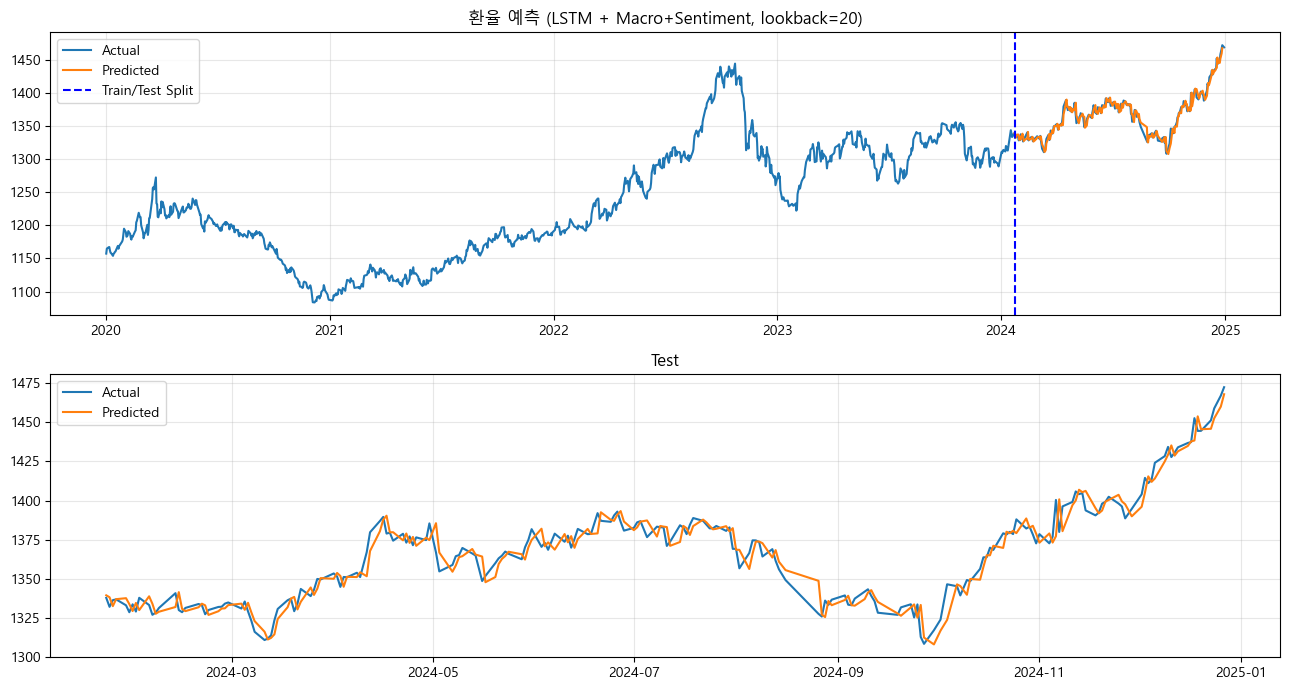

Saved: ./output_paper_protocol_lstm_resume\viz_LSTM_MacroSent_lb20_90\LSTM_MacroSent_lb20.png

[CHECK] LSTM | Macro+Sentiment | lookback=90 -> rows=146


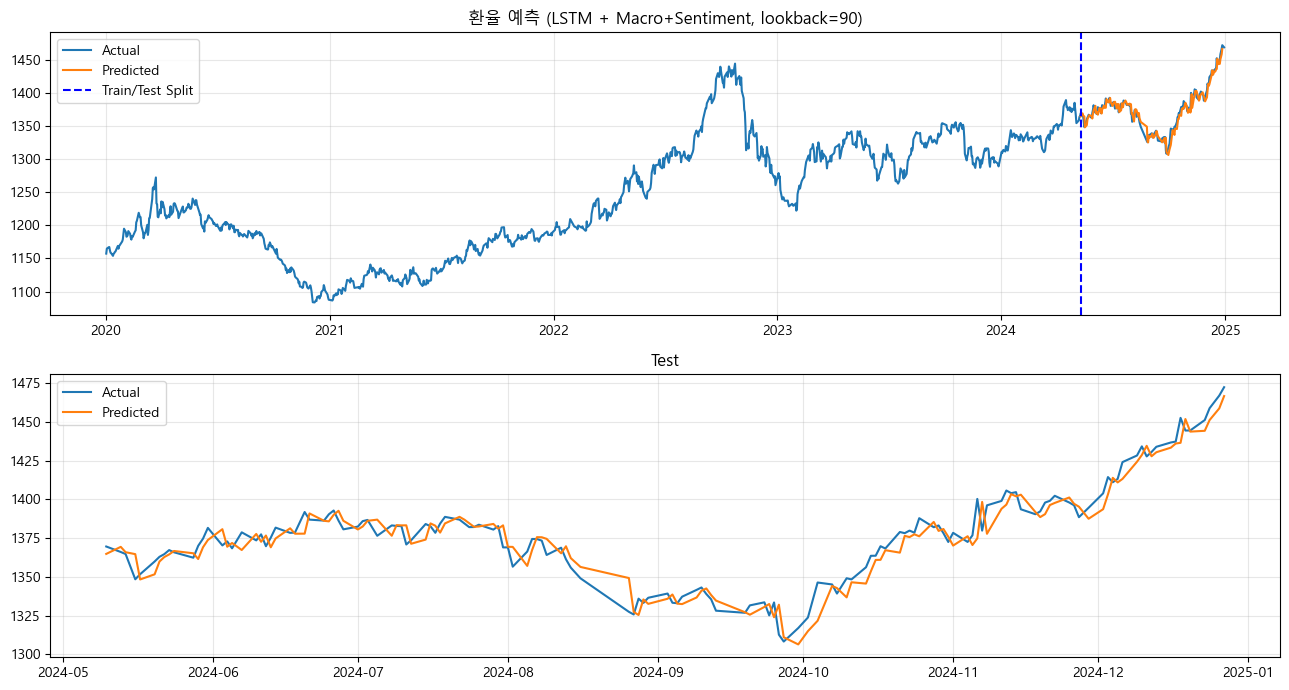

Saved: ./output_paper_protocol_lstm_resume\viz_LSTM_MacroSent_lb20_90\LSTM_MacroSent_lb90.png

✅ DONE


In [9]:
import os, glob, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ======================
# 0) 한글 폰트 설정
# ======================
def set_korean_font():
    if platform.system() == "Windows":
        font_path = "C:/Windows/Fonts/malgun.ttf"
    elif platform.system() == "Darwin":
        font_path = "/System/Library/Fonts/AppleGothic.ttf"
    else:
        font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

    if os.path.exists(font_path):
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rcParams["font.family"] = font_name
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# ======================
# 1) Config (LSTM 폴더)
# ======================
CSV_PATH   = "./2026/data/df_final_2026_with_gdelt_and_news.csv"
DATE_COL   = "date"
TARGET_COL = "USD_KRW 종가"

OUT_DIR = "./output_paper_protocol_lstm_resume"  
SAVE_DIR = os.path.join(OUT_DIR, "viz_LSTM_MacroSent_lb20_90")
os.makedirs(SAVE_DIR, exist_ok=True)

CASE_NAME  = "Macro + Sentiment"
MODEL_NAME = "LSTM"
SHIFT      = 1
LOOKBACKS  = [20, 90]

# ======================
# 2) LSTM prediction 파일 찾기
# ======================
pred_path = os.path.join(OUT_DIR, "holdout_predictions_final.csv")

if not os.path.exists(pred_path):
    pred_path = os.path.join(OUT_DIR, "holdout_predictions_partial.csv")

if not os.path.exists(pred_path):
    raise FileNotFoundError("LSTM holdout_predictions 파일이 없습니다!")

print("Pred file:", pred_path)

# ======================
# 3) 실제값 로드 (전체 기간)
# ======================
df_raw = pd.read_csv(CSV_PATH, encoding="utf-8-sig").replace([np.inf, -np.inf], np.nan)
df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL], errors="coerce")
df_raw = df_raw.sort_values(DATE_COL).dropna(subset=[DATE_COL, TARGET_COL]).reset_index(drop=True)

df_true_all = df_raw[[DATE_COL, TARGET_COL]].rename(columns={DATE_COL:"date", TARGET_COL:"y_true"})

# ======================
# 4) 예측값 로드
# ======================
df_pred = pd.read_csv(pred_path, encoding="utf-8-sig")
df_pred["date"] = pd.to_datetime(df_pred["date"], errors="coerce")
df_pred = df_pred.dropna(subset=["date","y_true","y_pred"])

print("\n[존재하는 조합]")
print(df_pred[["case","model","lookback","shift"]].drop_duplicates().to_string(index=False))

# seed 평균
def agg_seed_mean(df):
    if "seed" in df.columns:
        return df.groupby("date", as_index=False).agg(
            y_true=("y_true","mean"),
            y_pred=("y_pred","mean")
        )
    return df[["date","y_true","y_pred"]]

def plot_2panel(df_true_all, df_hold_pred, split_date, title, out_path):
    df_zoom = df_hold_pred[df_hold_pred["date"] >= split_date]

    fig, axes = plt.subplots(2, 1, figsize=(13, 7))
    ax1, ax2 = axes

    # 전체 기간
    ax1.plot(df_true_all["date"], df_true_all["y_true"], label="Actual", linewidth=1.5)
    ax1.plot(df_hold_pred["date"], df_hold_pred["y_pred"], label="Predicted", linewidth=1.5)
    ax1.axvline(split_date, linestyle="--", color="blue", label="Train/Test Split")
    ax1.set_title(title)
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 테스트 확대
    ax2.plot(df_zoom["date"], df_zoom["y_true"], label="Actual", linewidth=1.5)
    ax2.plot(df_zoom["date"], df_zoom["y_pred"], label="Predicted", linewidth=1.5)
    ax2.set_title("Test")
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()   
    plt.close(fig)

    print("Saved:", out_path)

# ======================
# 출력
# ======================
for lb in LOOKBACKS:
    sub = df_pred[
        (df_pred["case"] == CASE_NAME) &
        (df_pred["model"] == MODEL_NAME) &
        (df_pred["lookback"] == lb) &
        (df_pred["shift"] == SHIFT)
    ]

    print(f"\n[CHECK] LSTM | Macro+Sentiment | lookback={lb} -> rows={len(sub)}")

    if sub.empty:
        print("❌ ")
        continue

    sub_mean = agg_seed_mean(sub).sort_values("date")
    split_date = sub_mean["date"].min()

    title = f"환율 예측 (LSTM + Macro+Sentiment, lookback={lb})"
    out_path = os.path.join(SAVE_DIR, f"LSTM_MacroSent_lb{lb}.png")

    plot_2panel(df_true_all, sub_mean, split_date, title, out_path)

print("\n✅ DONE")


Saved paper summary CSV: ./20260123_paper_summary.csv
                       LABEL    model              case  lookback     RMSE     MSPE      MAE     MAPE    MedAE   MedAPE  SCORE_RMSE  SCORE_MSPE  SCORE_MAE  SCORE_MAPE  SCORE_MedAE  SCORE_MedAPE  SCORE_OVERALL
    [LSTM] Macro + Sentiment     LSTM Macro + Sentiment        90 7.638802 0.003099 5.870083 0.426785 4.206909 0.303889    0.557969    0.588207   0.663825    0.682133     1.000000      1.000000       0.748689
                   [GRU] ALL      GRU               ALL        60 7.463526 0.002979 5.690195 0.414877 4.314270 0.309037    0.661188    0.677351   0.775684    0.785252     0.956417      0.971754       0.804608
                   [GRU] ALL      GRU               ALL        90 7.641242 0.003124 5.750895 0.419061 4.261414 0.312370    0.556531    0.569709   0.737939    0.749024     0.977874      0.953467       0.757424
                  [LSTM] ALL     LSTM               ALL        90 7.269732 0.002822 5.563709 0.405123 4.334106

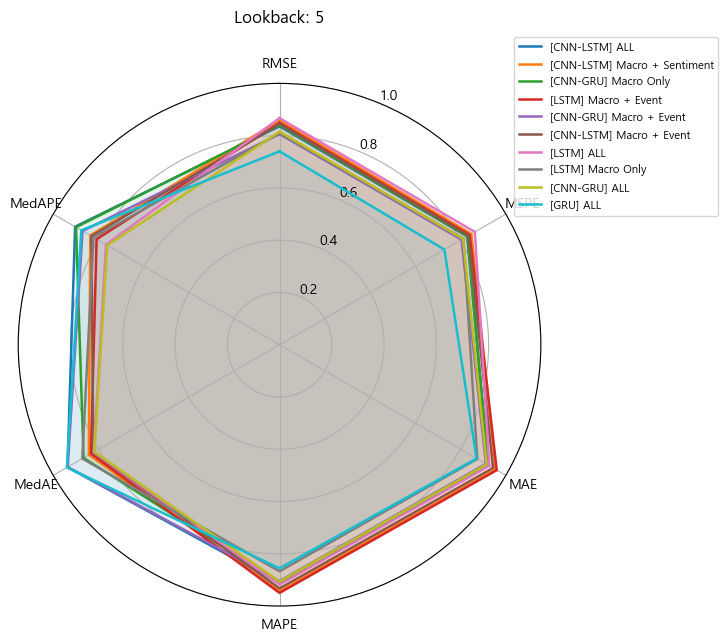

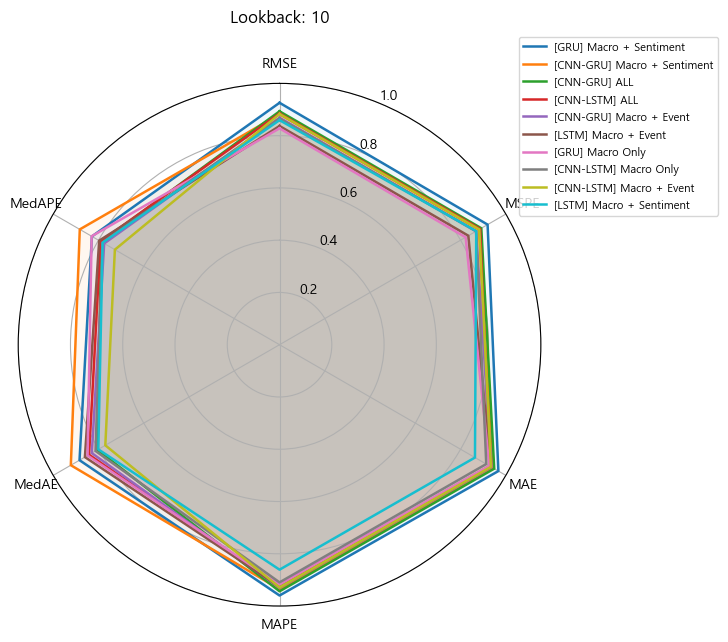

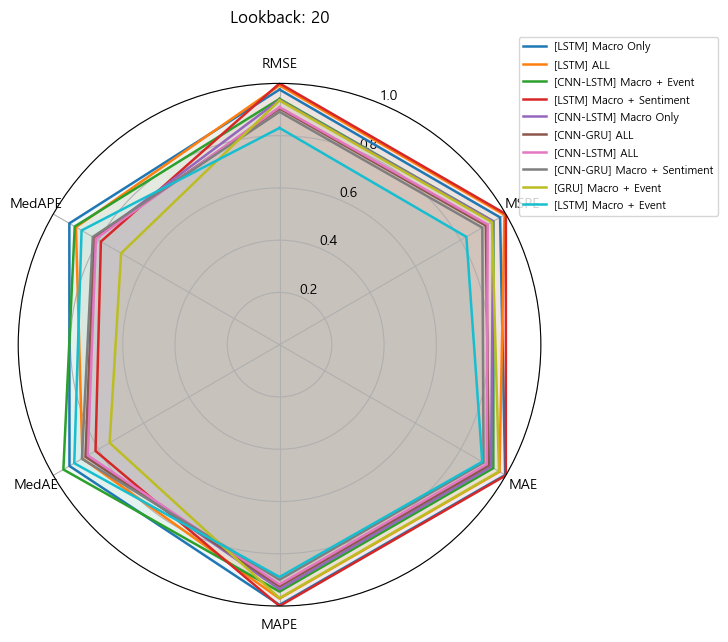

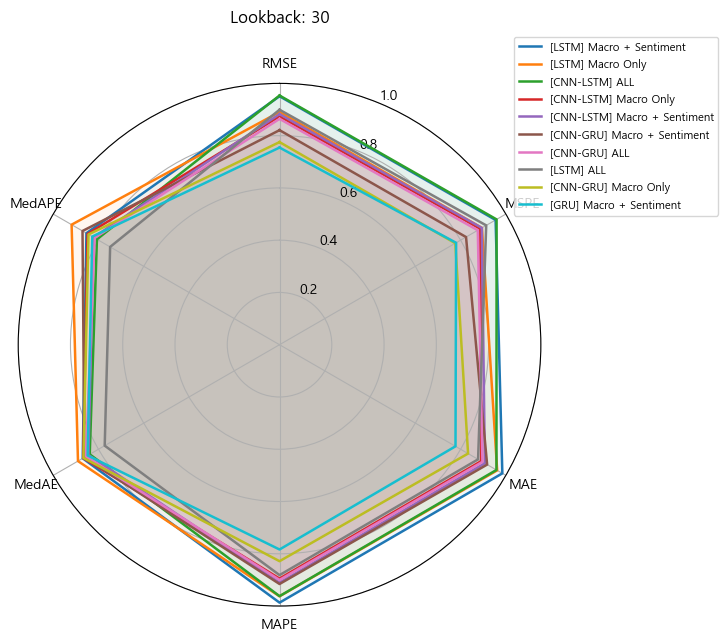

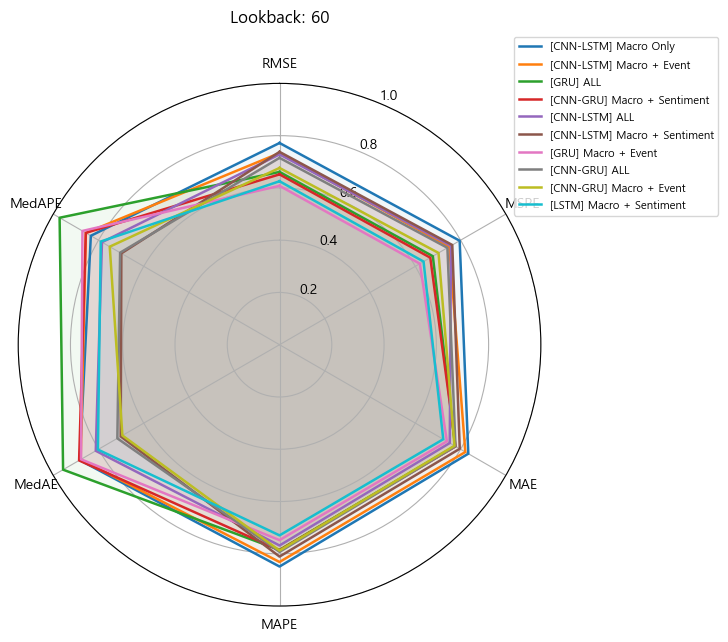

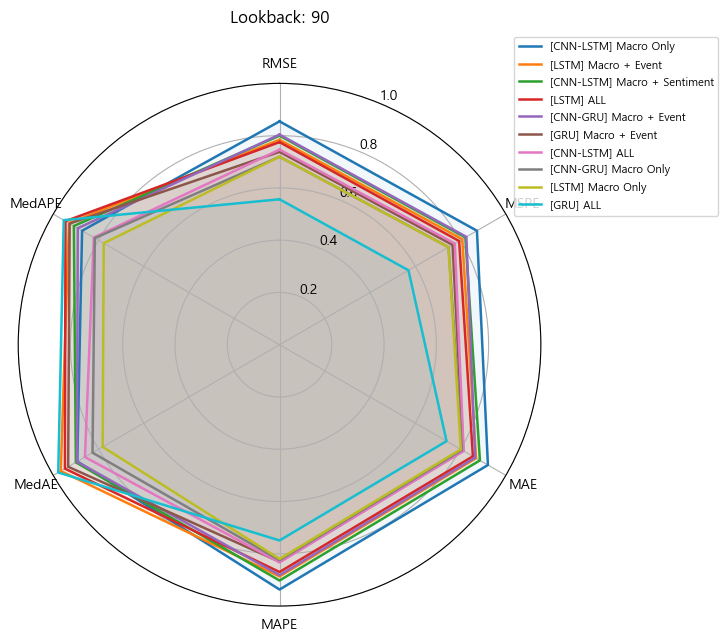


Saved best-by-lookback CSV: ./20260123_best_by_lookback.csv
                   LABEL    model              case  lookback     RMSE     MSPE      MAE     MAPE    MedAE   MedAPE  SCORE_RMSE  SCORE_MSPE  SCORE_MAE  SCORE_MAPE  SCORE_MedAE  SCORE_MedAPE  SCORE_OVERALL
       [LSTM] Macro Only     LSTM        Macro Only        20 6.928127 0.002578 5.334318 0.390581 4.383850 0.316873    0.976481    0.974495   0.996977    0.995648     0.928171      0.928764       0.966756
[LSTM] Macro + Sentiment     LSTM Macro + Sentiment        30 6.971835 0.002605 5.354464 0.391587 4.528137 0.330644    0.950742    0.954652   0.984449    0.986935     0.869599      0.853214       0.933265
 [GRU] Macro + Sentiment      GRU Macro + Sentiment        10 7.014245 0.002653 5.382616 0.394733 4.493225 0.335057    0.925767    0.919278   0.966944    0.959697     0.883771      0.829002       0.914077
   [CNN-LSTM] Macro Only CNN-LSTM        Macro Only        90 7.134949 0.002716 5.456896 0.397374 4.468872 0.327147    

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
file_location = "./20260123.xlsx"

METRIC_COLS = ["RMSE_mean","MSPE_mean","MAE_mean","MAPE_mean","MedAE_mean","MedAPE_mean"]
CASE_COL_CANDIDATES = ["case", "Feature Case", "FeatureCase", "feature_case"]
MODEL_COL_CANDIDATES = ["model", "Model"]
LOOKBACK_COL_CANDIDATES = ["lookback", "Lookback"]

TOP_RANKING = 10
SCORING_MODE = "global_minmax"   # "global_minmax" or "baseline_ratio"
BASELINE_PICK = None
EPS = 1e-12

# -------------------------
# Helpers
# -------------------------
def pick_col(df, candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of these columns found: {candidates}\nAvailable: {list(df.columns)}")
    return None

def load_xlsx_auto(path):
    xls = pd.ExcelFile(path)
    sheet = "Raw" if "Raw" in xls.sheet_names else xls.sheet_names[0]
    return pd.read_excel(path, sheet_name=sheet)

def ensure_numeric(df, cols):
    for c in cols:
        if c not in df.columns:
            raise KeyError(f"Missing metric col: {c}")
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def build_label(row, model_col, case_col):
    return f"[{row[model_col]}] {row[case_col]}"

def global_minmax_scores(df, metric_cols):
    mins = df[metric_cols].min(skipna=True)
    maxs = df[metric_cols].max(skipna=True)
    denom = (maxs - mins).replace(0, np.nan)
    score = 1.0 - (df[metric_cols] - mins) / denom
    score = score.clip(0, 1)
    return score, mins, maxs

def radar_plot(ax, labels, score_mat, metric_names, title=""):
    n = len(metric_names)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False).tolist()
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_names)

    ax.set_ylim(0, 1.0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2","0.4","0.6","0.8","1.0"])

    for i, lab in enumerate(labels):
        vals = score_mat[i].tolist()
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=1.8, label=lab)
        ax.fill(angles, vals, alpha=0.06)

    ax.set_title(title, y=1.10)
    ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.10), fontsize=8)

def strip_mean(s: str) -> str:
    return s.replace("_mean", "")

# -------------------------
# Load
# -------------------------
df = load_xlsx_auto(file_location)

model_col = pick_col(df, MODEL_COL_CANDIDATES, required=True)
case_col  = pick_col(df, CASE_COL_CANDIDATES, required=True)
lb_col    = pick_col(df, LOOKBACK_COL_CANDIDATES, required=True)

df = ensure_numeric(df, METRIC_COLS)
df = df.dropna(subset=[model_col, case_col, lb_col] + METRIC_COLS).copy()

df[model_col] = df[model_col].astype(str)
df[case_col]  = df[case_col].astype(str)

# -------------------------
# Scores
# -------------------------
if SCORING_MODE == "global_minmax":
    scores, gmins, gmaxs = global_minmax_scores(df, METRIC_COLS)
    for m in METRIC_COLS:
        df[f"SCORE_{m}"] = scores[m]
    df["SCORE_OVERALL"] = df[[f"SCORE_{m}" for m in METRIC_COLS]].mean(axis=1)

elif SCORING_MODE == "baseline_ratio":
    if BASELINE_PICK is None:
        raise ValueError("Set BASELINE_PICK = ('LSTM','Macro Only') etc when using baseline_ratio mode")

    b_model, b_case = BASELINE_PICK
    key_cols = [lb_col]

    base = df[(df[model_col] == b_model) & (df[case_col] == b_case)][key_cols + METRIC_COLS].copy()
    if base.empty:
        raise ValueError(f"Baseline rows not found for {BASELINE_PICK}")

    base = base.rename(columns={m: f"BASE_{m}" for m in METRIC_COLS})
    merged = df.merge(base, on=key_cols, how="left")

    for m in METRIC_COLS:
        merged[f"SCORE_{m}"] = merged[f"BASE_{m}"] / (merged[m] + EPS)

    merged["SCORE_OVERALL"] = merged[[f"SCORE_{m}" for m in METRIC_COLS]].mean(axis=1)
    df = merged.copy()

else:
    raise ValueError("Unknown SCORING_MODE")

df["LABEL"] = df.apply(lambda r: build_label(r, model_col, case_col), axis=1)

# -------------------------
# Save (rename columns to remove _mean) + print
# -------------------------
metric_rename = {m: strip_mean(m) for m in METRIC_COLS}
score_cols = [f"SCORE_{m}" for m in METRIC_COLS]
score_rename = {f"SCORE_{m}": f"SCORE_{strip_mean(m)}" for m in METRIC_COLS}

keep_cols = ["LABEL", model_col, case_col, lb_col] + METRIC_COLS + score_cols + ["SCORE_OVERALL"]
df_out = df[keep_cols].rename(columns={**metric_rename, **score_rename}).copy()

out_summary = "./20260123_paper_summary.csv"
df_out.to_csv(out_summary, index=False, encoding="utf-8-sig")
print("Saved paper summary CSV:", out_summary)
print(df_out.head(20).to_string(index=False))

# -------------------------
# Radar charts per lookback (TOP_RANKING by SCORE_OVERALL)
# -------------------------
metric_names_display = [strip_mean(m) for m in METRIC_COLS]
score_cols_out = [f"SCORE_{strip_mean(m)}" for m in METRIC_COLS]

for lookback in sorted(df[lb_col].unique()):
    df_sub = df[df[lb_col] == lookback].copy()
    df_sub = df_sub.sort_values("SCORE_OVERALL", ascending=False).head(TOP_RANKING)
    if df_sub.empty:
        continue

    labels = df_sub["LABEL"].tolist()
    score_mat = df_sub[[f"SCORE_{m}" for m in METRIC_COLS]].values

    fig = plt.figure(figsize=(8.5, 6.5))
    ax = plt.subplot(111, polar=True)
    radar_plot(
        ax=ax,
        labels=labels,
        score_mat=score_mat,
        metric_names=[m.replace("_mean","") for m in METRIC_COLS],  # 축 라벨에서 _mean 제거
        title=f"Lookback: {int(lookback)}"
    )
    plt.tight_layout()

    out_png = f"./radar_lookback_{int(lookback)}_{SCORING_MODE}_v2.png"
    plt.savefig(out_png, dpi=200)

    plt.show()     
    plt.close(fig)  

# -------------------------
# best-by-lookback table (paper table-ready) + print
# -------------------------
best_by_lb = (df.sort_values(["SCORE_OVERALL"], ascending=False)
               .groupby(lb_col, as_index=False)
               .head(1))

best_out = best_by_lb[keep_cols].rename(columns={**metric_rename, **score_rename}).copy()
out_best = "./20260123_best_by_lookback.csv"
best_out.to_csv(out_best, index=False, encoding="utf-8-sig")
print("\nSaved best-by-lookback CSV:", out_best)
print(best_out.to_string(index=False))

In [13]:
import matplotlib as mpl
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  
mpl.rcParams['axes.unicode_minus'] = False

# EDA

In [3]:
def eda_basic_info(df, df_name="DataFrame"):
    print(f"\n===== {df_name} =====")
    print("Head (5 rows):")
    display(df.head())

    print("\nInfo:")
    print(df.info())

    print("\nDescribe (numeric):")
    display(df.describe())

    print("\nNull counts:")
    print(df.isnull().sum())

    print("="*40)

In [21]:
pd.set_option('display.max_rows', None)        # 행 제한 해제
pd.set_option('display.max_columns', None)     # 열 제한 해제
pd.set_option('display.width', None)           # 가로 폭 제한 해제
pd.set_option('display.max_colwidth', None)    # 컬럼 내용 길이 제한 해제

CSV_PATH   = "./2026/data/df_final_2026_with_gdelt_and_news.csv"
df = pd.read_csv(CSV_PATH)
eda_basic_info(df, "df")


===== df =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,CPI,PPI,ksvkospi 종가,미국달러선물인버스,usd_jpy,usd_cny,us10y,copper,aluminum,vix,move,ovx,한국 정책금리,미국 정책금리,경상수지,nickel_price,gkg_doc_cnt,gkg_tone_mean,gkg_tone_std,gkg_pos_ratio,gkg_neu_ratio,gkg_neg_ratio,gkg_net_tone,gkg_kr_doc_cnt,gkg_kr_doc_share,gkg_kr_loc_cnt,gkg_kr_pos_ratio,gkg_kr_neu_ratio,gkg_kr_neg_ratio,gkg_kr_pos_tone_mean,gkg_kr_neu_tone_mean,gkg_kr_neg_tone_mean,gkg_kr_net_tone,gkg_kr_tone_std,events_total_cnt,events_kr_cnt,events_pos_ratio,events_neu_ratio,events_neg_ratio,events_pos_tone_mean,events_neg_tone_mean,news_total,news_direct,news_indirect,news_pos,news_neg,news_neu,sent_mean,sent_std,abs_sent_mean,direct_ratio,indirect_ratio,pos_ratio,neg_ratio,neu_ratio,sent_net_count,sent_net_ratio,news_total_roll3,sent_mean_roll3,sent_net_ratio_roll3,abs_sent_mean_roll3,news_total_roll7,sent_mean_roll7,sent_net_ratio_roll7,abs_sent_mean_roll7,news_total_roll14,sent_mean_roll14,sent_net_ratio_roll14,abs_sent_mean_roll14,news_total_lag1,news_direct_lag1,news_indirect_lag1,news_pos_lag1,news_neg_lag1,news_neu_lag1,sent_mean_lag1,sent_net_ratio_lag1,abs_sent_mean_lag1
0,2020-01-02,1157.35,1155.02,2175.17,494680000.0,674.02,7.837300e+08,61.19,1528.94,28868.80,254290000.0,3257.8,889.5836,2875.9288,0.7,-0.1,15.40,9895.0,108.712997,6.9622,0.1882,2.8330,1812.50,12.47,57.200001,28.750000,1.25,1.75,7.827,19.158600,75611,-0.933683,3.762877,0.308808,0.241159,0.450033,-0.937040,1396,0.018463,1801,0.320201,0.327364,0.352436,2.909767,0.035735,-2.864095,-0.077700,2.752181,123425,649,0.570108,0.175655,0.254237,4.464054,-5.073939,8.0,7.0,1.0,3.0,4.0,1.0,-0.125000,0.991031,0.875000,0.875000,0.125000,0.375000,0.500000,0.125000,-1.0,-0.125000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,8.0,7.0,1.0,2.0,3.0,3.0,-0.125000,-0.125000,0.625000
1,2020-01-03,1164.95,1157.95,2176.46,631560000.0,669.93,9.038600e+08,63.10,1551.65,28634.88,239590000.0,3234.8,889.5836,2875.9288,0.7,-0.1,15.88,9740.0,108.542999,6.9634,0.1788,2.7985,1830.00,14.02,60.119999,31.920000,1.25,1.75,7.827,18.542070,83567,-1.400818,3.877638,0.277685,0.218941,0.503375,-1.402603,1373,0.016430,1722,0.316824,0.289876,0.393299,2.755737,0.022085,-3.788105,-0.616775,3.132725,157403,423,0.513002,0.217494,0.269504,4.823963,-5.316667,11.0,10.0,1.0,2.0,7.0,2.0,-0.454545,0.820200,0.818182,0.909091,0.090909,0.181818,0.636364,0.181818,-5.0,-0.454545,27.0,-0.234848,-0.234848,0.772727,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,8.0,7.0,1.0,3.0,4.0,1.0,-0.125000,-0.125000,0.875000
2,2020-01-06,1166.94,1165.89,2155.07,592670000.0,655.31,8.842800e+08,62.99,1565.96,28703.38,261810000.0,3246.3,889.5836,2875.9288,0.7,-0.1,15.88,9655.0,107.963997,6.9645,0.1811,2.8005,1842.00,13.85,62.790001,32.320000,1.25,1.75,7.827,18.530100,87239,-1.082951,4.084765,0.310656,0.211147,0.478198,-1.087385,1823,0.020897,2120,0.514536,0.200219,0.285244,4.214261,0.075738,-3.932406,1.046695,4.043565,158919,636,0.542453,0.242138,0.215409,4.494783,-4.654015,12.0,10.0,2.0,1.0,9.0,2.0,-0.666667,0.651339,0.833333,0.833333,0.166667,0.083333,0.750000,0.166667,-8.0,-0.666667,32.0,-0.555556,-0.555556,0.744444,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,10.0,8.0,2.0,1.0,6.0,3.0,-0.500000,-0.500000,0.700000
3,2020-01-07,1167.30,1167.54,2175.54,568240000.0,663.44,9.703100e+08,64.92,1573.99,28583.68,266680000.0,3237.2,889.5836,2875.9288,0.7,-0.1,15.08,9750.0,108.405998,6.9745,0.1827,2.8040,1822.00,13.79,62.630001,31.799999,1.25,1.75,7.827,18.678329,97851,-1.188986,3.964910,0.302034,0.214624,0.483342,-1.191482,1745,0.017833,2273,0.403438,0.227507,0.369054,2.882625,0.084421,-3.386274,-0.086758,3.169415,179999,711,0.590717,0.227848,0.181435,4.712143,-4.564341,12.0,9.0,3.0,3.0,7.0,2.0,-0.333333,0.887625,0.833333,0.750000,0.250000,0.250000,0.583333,0.166667,-4.0,-0.333333,34.0,-0.500000,-0.500000,0.788889,71.0,-0.386364,-0.386364,0.769264,0.0,0.0,0.0,0.0,12.0,10.0,2.0,1.0,9.0,2.0,-0.666667,-


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 92 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1186 non-null   object 
 1   USD_KRW 종가             1186 non-null   float64
 2   USD_KRW 시가             1186 non-null   float64
 3   KOSPI 종가               1186 non-null   float64
 4   KOSPI 거래량              1186 non-null   float64
 5   KOSDAQ 종가              1186 non-null   float64
 6   KOSDAQ 거래량             1186 non-null   float64
 7   WTI Price              1186 non-null   float64
 8   XAU Price              1186 non-null   float64
 9   DJI 종가                 1186 non-null   float64
 10  DJI 거래량                1186 non-null   float64
 11  SP500 종가               1186 non-null   float64
 12  M1                     1186 non-null   float64
 13  M2                     1186 non-null   float64
 14  CPI                    1186 non-null   float64
 1

,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,CPI,PPI,ksvkospi 종가,미국달러선물인버스,usd_jpy,usd_cny,us10y,copper,aluminum,vix,move,ovx,한국 정책금리,미국 정책금리,경상수지,nickel_price,gkg_doc_cnt,gkg_tone_mean,gkg_tone_std,gkg_pos_ratio,gkg_neu_ratio,gkg_neg_ratio,gkg_net_tone,gkg_kr_doc_cnt,gkg_kr_doc_share,gkg_kr_loc_cnt,gkg_kr_pos_ratio,gkg_kr_neu_ratio,gkg_kr_neg_ratio,gkg_kr_pos_tone_mean,gkg_kr_neu_tone_mean,gkg_kr_neg_tone_mean,gkg_kr_net_tone,gkg_kr_tone_std,events_total_cnt,events_kr_cnt,events_pos_ratio,events_neu_ratio,events_neg_ratio,events_pos_tone_mean,events_neg_tone_mean,news_total,news_direct,news_indirect,news_pos,news_neg,news_neu,sent_mean,sent_std,abs_sent_mean,direct_ratio,indirect_ratio,pos_ratio,neg_ratio,neu_ratio,sent_net_count,sent_net_ratio,news_total_roll3,sent_mean_roll3,sent_net_ratio_roll3,abs_sent_mean_roll3,news_total_roll7,sent_mean_roll7,sent_net_ratio_roll7,abs_sent_mean_roll7,news_total_roll14,sent_mean_roll14,sent_net_ratio_roll14,abs_sent_mean_roll14,news_total_lag1,news_direct_lag1,news_indirect_lag1,news_pos_lag1,news_neg_lag1,news_neu_lag1,sent_mean_lag1,sent_net_ratio_lag1,abs_sent_mean_lag1
count,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000,1186.00000,1186.000000
mean,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1205.217857,3564.978455,2.770405,3.520236,20.305084,7820.442664,127.855599,6.867263,0.267769,3.820936,2313.546796,21.438035,93.222091,44.723179,2.035835,2.604553,5.123286,27.092645,88501.869309,-0.786042,3.727927,0.317322,0.235070,0.447608,-0.787078,1738.198988,0.019674,2371.216695,0.323766,0.260374,0.415860,2.892808,0.019798,-3.351614,-0.470914,3.053546,133581.210793,760.273187,0.597030,0.178449,0.222835,4.315440,-5.058331,13.890388,10.706577,3.183811,4.400506,7.373524,2.116358,-0.206461,0.716464,0.841593,0.764621,0.224418,0.317566,0.524027,0.147446,-2.973019,-0.206461,41.451939,-0.208433,-0.208433,0.838577,96.532040,-0.202323,-0.202323,0.832330,191.864250,-0.199530,-0.199530,0.828701,13.790051,10.521922,3.268128,4.332209,7.350759,2.107083,-0.20996,-0.20996,0.840395
std,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,119.929076,356.674359,1.711118,3.704028,6.604767,1478.855268,18.424688,0.318528,0.139671,0.631159,420.719798,8.368224,32.113382,24.293873,1.306016,2.318343,4.121523,6.371881,24450.602362,0.227154,0.171375,0.031315,0.013102,0.028119,0.225021,712.911312,0.005563,1004.779882,0.077889,0.051604,0.108024,0.294010,0.081979,0.415892,0.712539,0.318944,24788.607249,337.768807,0.068101,0.036846,0.058851,0.329617,0.651146,4.198829,4.478725,3.341079,3.996281,4.659506,2.679496,0.505095,0.282571,0.189114,0.222219,0.208459,0.261186,0.277893,0.167776,7.560900,0.505095,11.114508,0.414134,0.414134,0.162979,23.869923,0.364148,0.364148,0.155153,44.020202,0.286757,0.28675


Null counts:
date                     0
USD_KRW 종가               0
USD_KRW 시가               0
KOSPI 종가                 0
KOSPI 거래량                0
KOSDAQ 종가                0
KOSDAQ 거래량               0
WTI Price                0
XAU Price                0
DJI 종가                   0
DJI 거래량                  0
SP500 종가                 0
M1                       0
M2                       0
CPI                      0
PPI                      0
ksvkospi 종가              0
미국달러선물인버스                0
usd_jpy                  0
usd_cny                  0
us10y                    0
copper                   0
aluminum                 0
vix                      0
move                     0
ovx                      0
한국 정책금리                  0
미국 정책금리                  0
경상수지                     0
nickel_price             0
gkg_doc_cnt              0
gkg_tone_mean            0
gkg_tone_std             0
gkg_pos_ratio            0
gkg_neu_ratio            0
gkg_neg_ratio            0
gkg_net_tone  

In [22]:
def eda_basic_info2(df, df_name="DataFrame"):

    print("\nDescribe (numeric):")
    display(df.describe().T)  

eda_basic_info2(df, "df")


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
USD_KRW 종가,1186.0,1.256283e+03,9.374322e+01,1.083530e+03,1.181822e+03,1.265610e+03,1.333020e+03,1.472500e+03
USD_KRW 시가,1186.0,1.256633e+03,9.378730e+01,1.083870e+03,1.182460e+03,1.266325e+03,1.333395e+03,1.471100e+03
KOSPI 종가,1186.0,2.596073e+03,3.392823e+02,1.457640e+03,2.399310e+03,2.568480e+03,2.758637e+03,3.305210e+03
KOSPI 거래량,1186.0,7.131867e+08,3.554851e+08,8.245100e+05,4.629025e+08,6.137650e+08,8.662025e+08,3.460000e+09
KOSDAQ 종가,1186.0,8.411601e+02,1.144289e+02,4.283500e+02,7.621850e+02,8.475050e+02,9.194125e+02,1.060000e+03
KOSDAQ 거래량,1186.0,1.306049e+09,5.210409e+08,6.196200e+08,9.524700e+08,1.170000e+09,1.500000e+09,5.070000e+09
WTI Price,1186.0,6.953344e+01,2.329195e+01,7.790000e+00,6.209000e+01,7.373500e+01,8.203000e+01,1.264700e+02
XAU Price,1186.0,1.937514e+03,2.635906e+02,1.471000e+03,1.778307e+03,1.870390e+03,1.985455e+03,2.786190e+03
DJI 종가,1186.0,3.360314e+04,4.657789e+03,1.859193e+04,3.102209e+04,3.391362e+04,3.562782e+04,4.501404e+04
DJI 거래량,1186.0,3.687432e+08,1.128756e+08,1.170400e+08,3.016050e+08,3.433250e+08,4.021650e+08,1.220000e+09


# HitMap

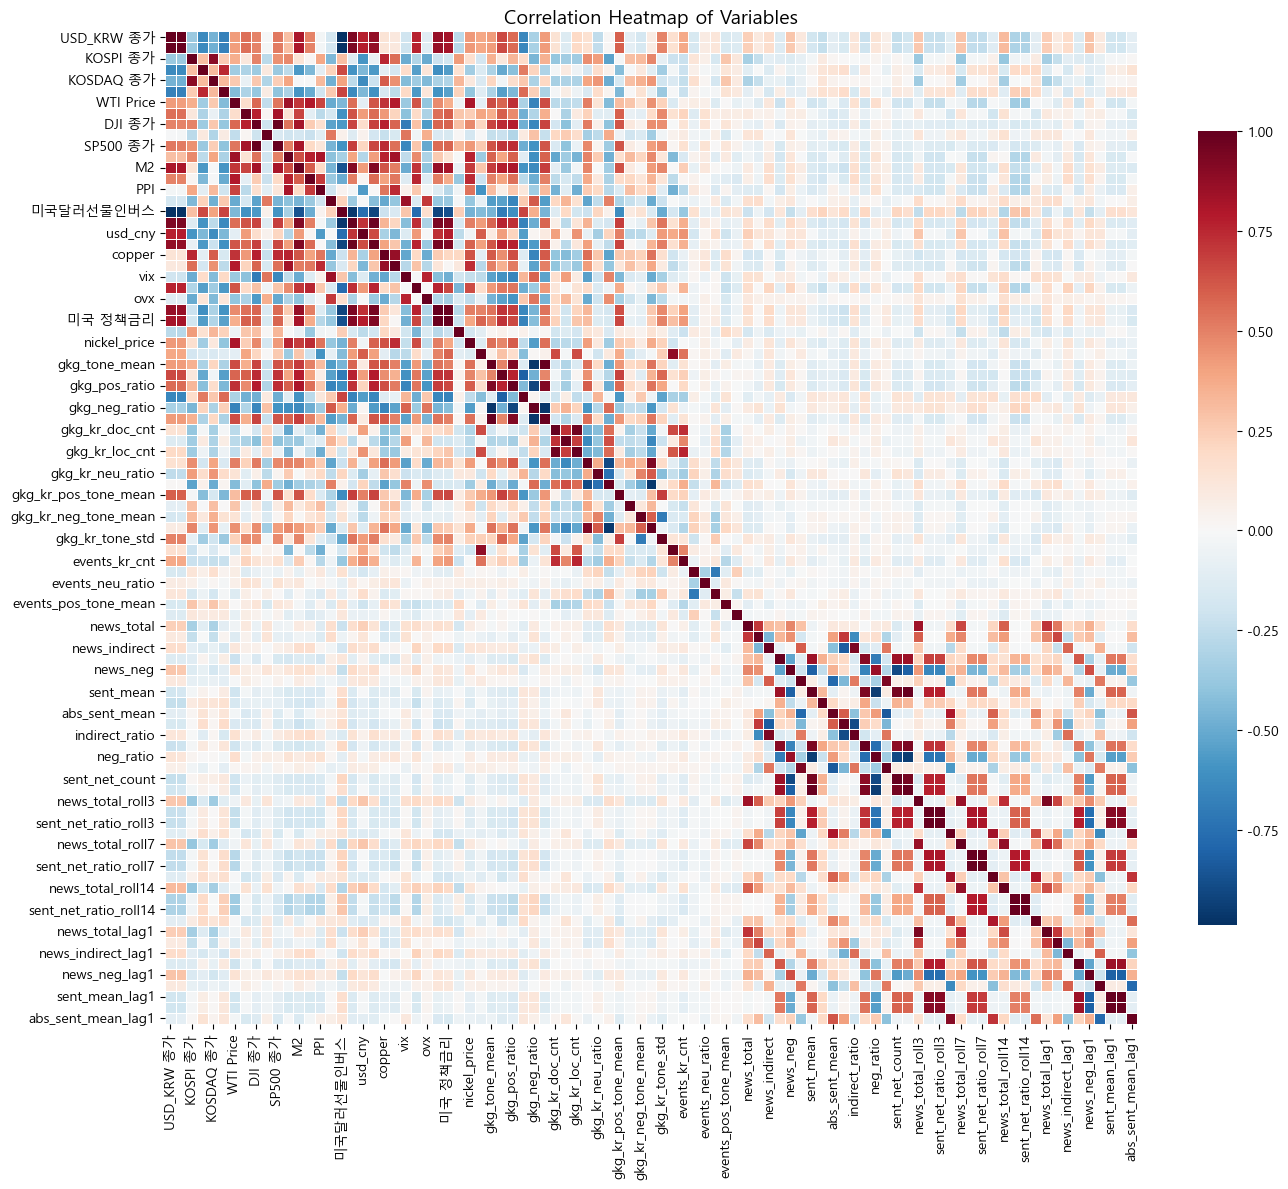

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

CSV_PATH   = "./2026/data/df_final_2026_with_gdelt_and_news.csv"
DATE_COL   = "date"
TARGET_COL = "USD_KRW 종가"

# Load dataset
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# 숫자형 변수만 선택 (타깃 포함)
num_df = df.select_dtypes(include=[np.number]).copy()

# news_count 제거
if "news_count" in num_df.columns:
    num_df = num_df.drop(columns=["news_count"])

# 결측치 제거
num_df = num_df.dropna()

# 상관관계 계산 (피어슨)
corr = num_df.corr(method="pearson")

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap="RdBu_r", center=0, annot=False, fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap of Variables", fontsize=14)
plt.tight_layout()
plt.show()